In [15]:
# -----------------------------------------------------------------------------
# 0. IMPORTAÇÕES DE BIBLIOTECAS
# -----------------------------------------------------------------------------
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
import base64
import io
import unicodedata

from datetime import datetime
from branca.element import Element
from PIL import Image
from IPython.display import display

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


In [16]:
# -----------------------------------------------------------------------------
# 1. CONFIGURAÇÕES GLOBAIS E DEFINIÇÃO DE CAMINHOS
#    (AJUSTE ESTA SEÇÃO CONFORME O SEU AMBIENTE E DADOS)
# -----------------------------------------------------------------------------

# --- A. Configuração do Google Drive (se estiver usando Colab) ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) # force_remount pode ser útil para garantir a montagem
    print("Google Drive montado com sucesso.")
    # Defina o caminho base DENTRO do seu Google Drive
    DRIVE_BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/FIAP/Global" # ⬅️ AJUSTE AQUI O CAMINHO DA SUA PASTA NO DRIVE
except ModuleNotFoundError:
    print("AVISO: Não está no ambiente Google Colab ou 'google.colab' não encontrado.")
    print("         Definindo DRIVE_BASE_PATH para o diretório atual como fallback.")
    DRIVE_BASE_PATH = "." # Diretório atual se não estiver no Colab
except Exception as e:
    print(f"Erro ao montar o Google Drive: {e}")
    print("         Definindo DRIVE_BASE_PATH para o diretório atual como fallback.")
    DRIVE_BASE_PATH = "."

# --- B. Caminhos para Arquivos e Pastas ---
# Use os.path.join para construir caminhos de forma segura entre sistemas operacionais
CAMINHO_ARQUIVO_CSV = os.path.join(DRIVE_BASE_PATH, "dados-inmet-sp.csv") # ⬅️ VERIFIQUE O NOME DO SEU ARQUIVO CSV
CAMINHO_DA_PASTA_DE_IMAGENS = os.path.join(DRIVE_BASE_PATH, "images")    # ⬅️ VERIFIQUE O NOME DA SUA PASTA DE IMAGENS
CAMINHO_PARA_SALVAR_OUTPUTS = os.path.join(DRIVE_BASE_PATH, "outputs_gerados") # ⬅️ PASTA PARA SALVAR MAPAS/RELATÓRIOS

# Criar pasta de outputs se não existir
if not os.path.exists(CAMINHO_PARA_SALVAR_OUTPUTS):
    try:
        os.makedirs(CAMINHO_PARA_SALVAR_OUTPUTS)
        print(f"Pasta de outputs criada em: {CAMINHO_PARA_SALVAR_OUTPUTS}")
    except Exception as e:
        print(f"Erro ao criar pasta de outputs '{CAMINHO_PARA_SALVAR_OUTPUTS}': {e}")
        print("Outputs serão salvos no diretório do script se a criação da pasta falhar.")
        CAMINHO_PARA_SALVAR_OUTPUTS = "."


# --- C. Parâmetros de Análise ---
EXTENSOES_IMAGEM_VALIDAS = ('.jpg', '.jpeg', '.png')
MEUS_LIMIARES_DE_ALERTA = [
    {'coluna_acumulado': 'prec_acum_1h', 'valor_mm': 25, 'nivel_alerta': 'ALERTA MÁXIMO', 'mensagem': 'Chuva MUITO FORTE em 1h (>25mm)'},
    {'coluna_acumulado': 'prec_acum_1h', 'valor_mm': 15, 'nivel_alerta': 'ALERTA', 'mensagem': 'Chuva FORTE em 1h (>15mm)'},
    {'coluna_acumulado': 'prec_acum_24h', 'valor_mm': 100, 'nivel_alerta': 'ALERTA MÁXIMO', 'mensagem': 'Acumulado >100mm em 24h - RISCO ALTO'},
    {'coluna_acumulado': 'prec_acum_24h', 'valor_mm': 70, 'nivel_alerta': 'ALERTA', 'mensagem': 'Acumulado >70mm em 24h - RISCO MODERADO'},
    {'coluna_acumulado': 'prec_acum_24h', 'valor_mm': 40, 'nivel_alerta': 'ATENÇÃO', 'mensagem': 'Acumulado >40mm em 24h - Atenção'},
    {'coluna_acumulado': 'prec_acum_72h', 'valor_mm': 150, 'nivel_alerta': 'ALERTA', 'mensagem': 'Acumulado >150mm em 72h (solo saturado)'},
]
MAPEAMENTO_REGIONAL_RELEVANCIA = { # Use minúsculas para chaves e valores (municípios)
    'são sebastião': ['bertioga', 'são sebastião', 'caraguatatuba', 'ilhabela'],
    'bertioga': ['bertioga', 'são sebastião', 'guarujá', 'santos'],
    'caraguatatuba': ['caraguatatuba', 'são sebastião', 'ubatuba'],
    'ubatuba': ['ubatuba', 'caraguatatuba'],
    'guarujá': ['guarujá', 'santos', 'bertioga'],
    'santos': ['santos', 'guarujá', 'são vicente'],
    # Adicione outros mapeamentos conforme suas imagens e a lógica de proximidade/relevância.
    # Ex: 'nome_municipio_na_imagem': ['municipio_da_estacao_1_relevante', 'municipio_da_estacao_2_relevante']
}
PALAVRAS_CHAVE_LOCAIS_IMAGEM = ['são sebastião', 'bertioga', 'caraguatatuba', 'ubatuba', 'ilhabela', 'guarujá', 'santos', 'são paulo'] # Minúsculas. Usado para inferir local da imagem.

print("Configurações globais definidas.")
print(f"Tentando ler CSV de: {CAMINHO_ARQUIVO_CSV}")
print(f"Tentando ler imagens de: {CAMINHO_DA_PASTA_DE_IMAGENS}")
print(f"Outputs serão salvos em: {CAMINHO_PARA_SALVAR_OUTPUTS}")

Mounted at /content/drive
Google Drive montado com sucesso.
Configurações globais definidas.
Tentando ler CSV de: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/dados-inmet-sp.csv
Tentando ler imagens de: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/images
Outputs serão salvos em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados


In [17]:
def extrair_data_de_nome_arquivo(nome_arquivo):
    # (Definição da função como fornecida anteriormente)
    match_iso = re.search(r'(\d{4})-(\d{2})-(\d{2})', nome_arquivo)
    if match_iso:
        ano, mes, dia = map(int, match_iso.groups())
        try: return datetime(ano, mes, dia).date()
        except ValueError: pass
    match_dmY = re.search(r'(\d{2})-(\d{2})-(\d{4})', nome_arquivo)
    if match_dmY:
        dia, mes, ano = map(int, match_dmY.groups())
        try: return datetime(ano, mes, dia).date()
        except ValueError: pass
    return None

In [18]:
def criar_thumbnail_base64(caminho_completo_imagem, largura_max=200, qualidade=75):
    # (Definição da função como fornecida anteriormente)
    try:
        img = Image.open(caminho_completo_imagem)
        ratio = largura_max / float(img.size[0])
        altura_max = int(float(img.size[1]) * float(ratio))
        img = img.resize((largura_max, altura_max), Image.Resampling.LANCZOS)
        if img.mode == 'RGBA' or img.mode == 'P':
            img = img.convert('RGB')
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=qualidade)
        img_bytes = buffer.getvalue()
        b64_string = base64.b64encode(img_bytes).decode('utf-8')
        return f'<img src="data:image/jpeg;base64,{b64_string}" alt="{os.path.basename(caminho_completo_imagem)}" style="display:block; margin-bottom:5px;"/>'
    except FileNotFoundError:
        return f"<i>Imagem não encontrada: {os.path.basename(caminho_completo_imagem)}</i>"
    except Exception as e:
        return f"<i>Erro ao processar imagem {os.path.basename(caminho_completo_imagem)}: {e}</i>"

print("Funções auxiliares definidas.")

Funções auxiliares definidas.


# -----------------------------------------------------------------------------
# 3. FUNÇÕES PRINCIPAIS DE PROCESSAMENTO DE DADOS
# -----------------------------------------------------------------------------

In [19]:
def carregar_dados_climaticos(caminho_arquivo_csv, **kwargs):
    # (Definição da função como fornecida anteriormente, já com a correção do FutureWarning)
    # Removendo os defaults dos nomes das colunas dos argumentos da função para pegá-los de kwargs
    # ou definir internamente se não passados.
    config_cols = {
        'nome_coluna_data_completa':'data', 'nome_coluna_hora_completa':'hora',
        'nome_coluna_precipitacao':'precipitacao_total', 'nome_coluna_estacao':'estacao',
        'nome_coluna_latitude':'latitude', 'nome_coluna_longitude':'longitude',
        'nome_coluna_municipio':'municipio', 'nome_coluna_estado':'estado',
        'linhas_cabecalho':0, 'separador':',', 'codificacao':'utf-8', 'formato_decimal':'.'
    }
    # Sobrescrever defaults com o que foi passado em kwargs
    config_cols.update(kwargs)

    try:
        df = pd.read_csv(
            caminho_arquivo_csv,
            skiprows=config_cols['linhas_cabecalho'],
            sep=config_cols['separador'],
            encoding=config_cols['codificacao'],
            decimal=config_cols['formato_decimal'],
            na_values=['', ' ', 'NULL', '-9999', '#N/D', '*****'] # Mais valores NA
        )
        print(f"Arquivo '{caminho_arquivo_csv}' lido com sucesso ({len(df)} linhas).")
    except FileNotFoundError:
        print(f"ERRO FATAL: O arquivo '{caminho_arquivo_csv}' não foi encontrado.")
        return None
    except Exception as e:
        print(f"ERRO FATAL ao ler o arquivo CSV '{caminho_arquivo_csv}': {e}")
        return None

    colunas_map = {
        'data_str':     config_cols['nome_coluna_data_completa'],
        'hora_str':     config_cols['nome_coluna_hora_completa'],
        'precipitacao': config_cols['nome_coluna_precipitacao'],
        'estacao':      config_cols['nome_coluna_estacao'],
        'latitude':     config_cols['nome_coluna_latitude'],
        'longitude':    config_cols['nome_coluna_longitude'],
        'municipio':    config_cols['nome_coluna_municipio'],
        'estado':       config_cols['nome_coluna_estado']
    }
    colunas_para_renomear = {} # {nome_no_csv: nome_logico}
    colunas_logicas_obrigatorias = ['data_str', 'hora_str', 'precipitacao', 'estacao']
    colunas_logicas_finais = []

    for nome_logico, nome_no_csv in colunas_map.items():
        if nome_no_csv in df.columns:
            colunas_para_renomear[nome_no_csv] = nome_logico
            colunas_logicas_finais.append(nome_logico)
        elif nome_logico in colunas_logicas_obrigatorias:
            print(f"ERRO FATAL: Coluna obrigatória '{nome_no_csv}' (para '{nome_logico}') não encontrada no CSV.")
            print(f"Colunas disponíveis no CSV: {df.columns.tolist()}")
            return None

    df_selecionado = df[list(colunas_para_renomear.keys())].copy()
    df_selecionado.rename(columns=colunas_para_renomear, inplace=True)

    # Limpeza e conversão de tipos
    df_selecionado['precipitacao'] = pd.to_numeric(df_selecionado['precipitacao'], errors='coerce').fillna(0)
    # Para colunas de coordenadas, também converter e lidar com erros (ex: vírgula decimal)
    for col_coord in ['latitude', 'longitude']:
        if col_coord in df_selecionado.columns:
            if df_selecionado[col_coord].dtype == 'object': # Se for string, tentar converter vírgula
                 df_selecionado[col_coord] = df_selecionado[col_coord].str.replace(',', '.', regex=False)
            df_selecionado[col_coord] = pd.to_numeric(df_selecionado[col_coord], errors='coerce')


    # Criar timestamp
    try:
        # Tentar formatos comuns de hora (HH:MM:SS ou HHMM)
        # Se a coluna hora_str for numérica (ex: 0, 100, 1200), formatar
        if pd.api.types.is_numeric_dtype(df_selecionado['hora_str']) or \
           (df_selecionado['hora_str'].dtype == 'object' and df_selecionado['hora_str'].str.match(r'^\d{1,4}$').all()):
            df_selecionado['hora_formatada'] = df_selecionado['hora_str'].astype(str).str.zfill(4).str.slice_replace(2, 2, ':') + ':00'
        else: # Assumir que já é HH:MM ou HH:MM:SS
            df_selecionado['hora_formatada'] = df_selecionado['hora_str'].astype(str)
            # Garantir que tenha segundos se for HH:MM
            df_selecionado['hora_formatada'] = df_selecionado['hora_formatada'].apply(
                lambda x: x if len(x.split(':')) == 3 else (x + ':00' if len(x.split(':')) == 2 else '00:00:00')
            )


        datetime_str = df_selecionado['data_str'].astype(str) + ' ' + df_selecionado['hora_formatada']
        df_selecionado['timestamp'] = pd.to_datetime(datetime_str, errors='coerce') # Tentar inferir formato ou especificar
    except Exception as e:
        print(f"ERRO FATAL ao converter data e hora para timestamp: {e}")
        return None

    df_selecionado.dropna(subset=['timestamp'], inplace=True) # Remove linhas onde timestamp falhou
    df_selecionado.set_index('timestamp', inplace=True)

    df_final = df_selecionado[colunas_logicas_finais] # Usa a lista de colunas lógicas que realmente existem

    print(f"Dados carregados e processados: {len(df_final)} linhas válidas.")
    if not df_final.empty:
        print("\n--- Amostra dos dados processados (carregamento) ---")
        print(df_final.head())
        # df_final.info() # Descomente para ver info detalhada
    return df_final

In [20]:
def calcular_precipitacao_acumulada(df, janelas_horas=[1, 3, 6, 12, 24, 48, 72]):
    # (Definição da função como fornecida anteriormente)
    if df is None or df.empty:
        print("DataFrame de entrada para calcular acumulados está vazio. Pulando.")
        return None
    if not isinstance(df, pd.DataFrame):
        print("Erro: A entrada não é um DataFrame do Pandas.")
        return None
    if 'precipitacao' not in df.columns:
        print("Erro: Coluna 'precipitacao' não encontrada.")
        return None
    if 'estacao' not in df.columns:
        print("Erro: Coluna 'estacao' não encontrada. Cálculo por estação não é possível.")
        return None
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Erro: O DataFrame não possui um DatetimeIndex.")
        return None

    print(f"\nCalculando precipitação acumulada para janelas: {janelas_horas} horas...")
    df_copia = df.copy()
    # Garantir ordenação correta antes do groupby().rolling()
    df_copia.sort_values(by=['estacao', df_copia.index.name], inplace=True)


    for janela_h in janelas_horas:
        nome_coluna_acumulada = f'prec_acum_{janela_h}h'
        print(f"  Calculando para {janela_h}h...")
        # Usar transform para aplicar a soma rolante agrupada e manter o índice original
        # Ou o método anterior com reset_index se for mais claro/funcionar melhor com a versão do pandas
        try:
             df_copia[nome_coluna_acumulada] = df_copia.groupby('estacao')['precipitacao'] \
                                               .rolling(window=janela_h, min_periods=1) \
                                               .sum() \
                                               .reset_index(level='estacao', drop=True)
        except Exception as e:
            print(f"    Aviso: Erro ao calcular {nome_coluna_acumulada} - {e}. Tentando com transform...")
            try:
                # Alternativa com transform (pode ser mais lenta em alguns casos, mas mais robusta com índices)
                df_copia[nome_coluna_acumulada] = df_copia.groupby('estacao')['precipitacao'] \
                                                      .transform(lambda x: x.rolling(window=janela_h, min_periods=1).sum())
            except Exception as e_transform:
                 print(f"    ERRO: Falha ao calcular {nome_coluna_acumulada} com ambos os métodos - {e_transform}. Coluna não será criada.")
                 continue # Pula para a próxima janela

    print("Cálculo de precipitação acumulada concluído.")
    if not df_copia.empty:
        print("\n--- Amostra dos dados com acumulados ---")
        # Mostra colunas que começam com 'prec' e a 'estacao'
        cols_to_show = ['estacao'] + [col for col in df_copia.columns if col.startswith('prec')]
        print(df_copia[cols_to_show].head())
    return df_copia

In [21]:
def gerar_alertas_precipitacao(df_dados, limiares):
    # (Definição da função como fornecida anteriormente)
    if df_dados is None or df_dados.empty:
        print("DataFrame de entrada para gerar alertas está vazio. Pulando.")
        return pd.DataFrame() # Retorna DataFrame vazio
    # ... (validações como antes)
    if not isinstance(df_dados, pd.DataFrame) or not isinstance(df_dados.index, pd.DatetimeIndex):
        print("Erro: df_dados deve ser um DataFrame com DatetimeIndex.")
        return pd.DataFrame()
    if not isinstance(limiares, list) or not all(isinstance(item, dict) for item in limiares):
        print("Erro: limiares deve ser uma lista de dicionários.")
        return pd.DataFrame()
    if 'estacao' not in df_dados.columns:
        print("Erro: Coluna 'estacao' não encontrada no DataFrame.")
        return pd.DataFrame()

    alertas_gerados = []
    print("\nVerificando alertas...")
    colunas_extras_possiveis = ['latitude', 'longitude', 'municipio', 'estado']

    for _, linha in df_dados.iterrows(): # Iterar pode ser lento para DataFrames muito grandes
        timestamp = linha.name
        nome_estacao = linha['estacao']
        dados_extras_estacao = {col_extra: linha.get(col_extra) for col_extra in colunas_extras_possiveis if col_extra in linha.index}

        for limiar in limiares:
            coluna_gatilho = limiar['coluna_acumulado']
            valor_limite = limiar['valor_mm']
            nivel = limiar['nivel_alerta']
            msg_template = limiar['mensagem']

            if coluna_gatilho in linha.index: # Verificar se a coluna de acumulado existe na linha
                valor_observado = linha[coluna_gatilho]
                if pd.notna(valor_observado) and valor_observado > valor_limite:
                    alerta = {
                        'timestamp': timestamp,
                        'estacao': nome_estacao,
                        'nivel_alerta': nivel,
                        'descricao_alerta': msg_template,
                        'coluna_trigger': coluna_gatilho,
                        'valor_observado_mm': valor_observado,
                        'limiar_mm': valor_limite
                    }
                    alerta.update(dados_extras_estacao)
                    alertas_gerados.append(alerta)
            else: # Debug
                print(f"Aviso: Coluna de gatilho '{coluna_gatilho}' não encontrada para a estação {nome_estacao} em {timestamp}.")

    if not alertas_gerados:
        print("Nenhum alerta gerado com os critérios atuais.")
        return pd.DataFrame()

    df_alertas = pd.DataFrame(alertas_gerados)
    niveis_ordem = ['ATENÇÃO', 'ALERTA', 'ALERTA MÁXIMO']
    if not df_alertas.empty and 'nivel_alerta' in df_alertas.columns:
        df_alertas['nivel_alerta'] = pd.Categorical(df_alertas['nivel_alerta'], categories=niveis_ordem, ordered=True)
        # Assegurar que colunas para ordenação existem antes de usá-las
        cols_para_sort = ['timestamp', 'estacao', 'nivel_alerta_cat' if 'nivel_alerta_cat' in df_alertas else 'nivel_alerta']
        # Verificar se 'nivel_alerta_cat' foi criada ou se 'nivel_alerta' é categórica
        if 'nivel_alerta_cat' not in df_alertas and isinstance(df_alertas['nivel_alerta'].dtype, pd.CategoricalDtype):
             df_alertas.sort_values(by=['timestamp', 'estacao', 'nivel_alerta'], ascending=[True, True, False], inplace=True)
        elif 'nivel_alerta_cat' in df_alertas : # Se criamos a categórica com outro nome
             df_alertas.sort_values(by=['timestamp', 'estacao', 'nivel_alerta_cat'], ascending=[True, True, False], inplace=True)


    print(f"{len(df_alertas)} alertas gerados.")
    if not df_alertas.empty:
        print("\n--- Amostra dos alertas gerados ---")
        print(df_alertas.head())
    return df_alertas

print("Funções principais de processamento definidas.")

Funções principais de processamento definidas.


# -----------------------------------------------------------------------------
# 4. FUNÇÕES DE VISUALIZAÇÃO E RELATÓRIO
# -----------------------------------------------------------------------------

In [22]:
def plotar_analise_chuva_estacao(df_acumulados, nome_estacao_analise,
                                 data_inicio_plot, data_fim_plot,
                                 limiares_alerta, nomes_imagens_evento, caminho_para_salvar_plot=None):
    # (Definição da função como fornecida anteriormente)
    # Adicionado caminho_para_salvar_plot
    if df_acumulados is None or df_acumulados.empty:
        print(f"DataFrame df_acumulados está vazio. Não é possível plotar para {nome_estacao_analise}.")
        return
    try:
        if not pd.api.types.is_datetime64_any_dtype(df_acumulados.index):
            print("Erro: O índice do DataFrame df_acumulados não é do tipo datetime.")
            return
        estacao_data = df_acumulados[df_acumulados['estacao'] == nome_estacao_analise].copy()
        estacao_data_periodo = estacao_data.loc[data_inicio_plot:data_fim_plot]
    except KeyError:
        print(f"Erro: Estação '{nome_estacao_analise}' não encontrada ou período inválido.")
        return
    except Exception as e:
        print(f"Erro ao filtrar dados para plotagem: {e}")
        return

    if estacao_data_periodo.empty:
        print(f"Nenhum dado para '{nome_estacao_analise}' no período {data_inicio_plot} a {data_fim_plot}.")
        return

    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax1.bar(estacao_data_periodo.index, estacao_data_periodo['precipitacao'],
            color='deepskyblue', alpha=0.7, width=0.03, label='Precipitação Horária (mm)')
    ax1.set_xlabel('Data e Hora')
    ax1.set_ylabel('Precipitação Horária (mm)', color='deepskyblue')
    ax1.tick_params(axis='y', labelcolor='deepskyblue')
    ax1.set_ylim(bottom=0)
    ax2 = ax1.twinx()
    if 'prec_acum_24h' in estacao_data_periodo.columns:
        ax2.plot(estacao_data_periodo.index, estacao_data_periodo['prec_acum_24h'],
                 color='red', marker='o', linestyle='-', markersize=4, linewidth=2, label='Acumulado 24h (mm)')
        ax2.set_ylabel('Precipitação Acumulada 24h (mm)', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_ylim(bottom=0)

    cores_limiar = {'ATENÇÃO': 'gold', 'ALERTA': 'darkorange', 'ALERTA MÁXIMO': 'crimson'}
    limiares_plotados_24h = set()
    for limiar in limiares_alerta:
        if limiar['coluna_acumulado'] == 'prec_acum_24h':
            valor_mm, nivel = limiar['valor_mm'], limiar['nivel_alerta']
            cor = cores_limiar.get(nivel, 'gray')
            if valor_mm not in limiares_plotados_24h:
                ax2.axhline(y=valor_mm, color=cor, linestyle='--', linewidth=1.5, label=f'{nivel} (24h: {valor_mm}mm)')
                limiares_plotados_24h.add(valor_mm)

    datas_imagens_plotadas = set()
    for nome_img in nomes_imagens_evento: # Usa a lista de todas as imagens globais
        data_imagem_obj = extrair_data_de_nome_arquivo(nome_img)
        if data_imagem_obj:
            datetime_imagem = datetime.combine(data_imagem_obj, datetime.min.time())
            # Verifica se a data da imagem está no período do gráfico
            # Convertendo string para timestamp para comparação segura
            ts_inicio_plot = pd.Timestamp(data_inicio_plot)
            # Adicionar 1 dia ao fim_plot para incluir todo o dia final na comparação
            ts_fim_plot = pd.Timestamp(data_fim_plot) + pd.Timedelta(days=1)

            if ts_inicio_plot <= datetime_imagem < ts_fim_plot : # Usar < para o limite superior se não quiser incluir o início do dia seguinte
                if data_imagem_obj not in datas_imagens_plotadas:
                    ax1.axvline(x=datetime_imagem, color='green', linestyle=':', linewidth=2, label=f'Imagem ({data_imagem_obj.strftime("%d/%m")})')
                    datas_imagens_plotadas.add(data_imagem_obj)

    plt.title(f'Análise de Chuva - Estação: {nome_estacao_analise}\nPeríodo: {data_inicio_plot} a {data_fim_plot}', fontsize=16)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    unique_labels2 = {}
    final_handles2, final_labels2 = [], []
    for handle, label in zip(handles2, labels2):
        if label not in unique_labels2: unique_labels2[label] = handle; final_handles2.append(handle); final_labels2.append(label)
    ax2.legend(handles1 + final_handles2, labels1 + final_labels2, loc='upper left', fontsize=10)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
    plt.xticks(rotation=30, ha='right') # Melhorar rotação
    fig.tight_layout()
    plt.grid(True, linestyle=':', alpha=0.6)

    if caminho_para_salvar_plot:
        try:
            nome_arquivo_plot = f"plot_chuva_{nome_estacao_analise.replace(' ', '_')}_{data_inicio_plot}_a_{data_fim_plot}.png"
            caminho_completo_plot = os.path.join(caminho_para_salvar_plot, nome_arquivo_plot)
            plt.savefig(caminho_completo_plot, bbox_inches='tight', dpi=100)
            print(f"Gráfico salvo em: {caminho_completo_plot}")
        except Exception as e:
            print(f"Erro ao salvar o gráfico: {e}")
    plt.show() # Mostra o gráfico

In [23]:
def plotar_mapa_estacoes(df_dados_base, caminho_para_salvar_mapa=None):
    # (Definição da função como fornecida anteriormente)
    if df_dados_base is None or df_dados_base.empty:
        print("DataFrame de dados base está vazio. Não é possível plotar o mapa de estações.")
        return None
    if not all(col in df_dados_base.columns for col in ['latitude', 'longitude', 'estacao', 'municipio']):
        print("Erro: DataFrame deve conter as colunas 'latitude', 'longitude', 'estacao', 'municipio'.")
        return None

    estacoes_unicas = df_dados_base.dropna(subset=['latitude', 'longitude'])
    estacoes_unicas = estacoes_unicas.drop_duplicates(subset=['estacao'], keep='first').copy() # Usar .copy()

    if estacoes_unicas.empty:
        print("Nenhuma estação com dados de latitude/longitude válidos encontrada.")
        return None
    print(f"\nPlotando mapa com {len(estacoes_unicas)} estações únicas...")

    # Assegurar que lat/lon são numéricos antes de calcular média
    estacoes_unicas['latitude'] = pd.to_numeric(estacoes_unicas['latitude'], errors='coerce')
    estacoes_unicas['longitude'] = pd.to_numeric(estacoes_unicas['longitude'], errors='coerce')
    estacoes_unicas.dropna(subset=['latitude', 'longitude'], inplace=True) # Remover se a conversão falhou

    if estacoes_unicas.empty: # Verificar novamente após coerção
        map_center_lat, map_center_lon = -23.5505, -46.6333 # Fallback SP
    else:
        map_center_lat = estacoes_unicas['latitude'].mean()
        map_center_lon = estacoes_unicas['longitude'].mean()

    mapa_estacoes = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=7, width='80%', height='80%')
    for _, estacao_info in estacoes_unicas.iterrows():
        try:
            lat, lon = float(estacao_info['latitude']), float(estacao_info['longitude'])
            nome, municipio = estacao_info['estacao'], estacao_info.get('municipio', 'N/A') # Usar .get()
            popup_html = f"<b>Estação:</b> {nome}<br><b>Município:</b> {municipio}<br><b>Lat:</b> {lat:.4f}, <b>Lon:</b> {lon:.4f}"
            folium.Marker(location=[lat, lon], popup=folium.Popup(popup_html, max_width=300), tooltip=nome).add_to(mapa_estacoes)
        except ValueError:
            print(f"Aviso: Coordenadas inválidas para estação {estacao_info.get('estacao', 'Desconhecida')}. Pulando.")

    if caminho_para_salvar_mapa:
        try:
            nome_arquivo_mapa = "mapa_todas_estacoes.html"
            caminho_completo_mapa = os.path.join(caminho_para_salvar_mapa, nome_arquivo_mapa)
            mapa_estacoes.save(caminho_completo_mapa)
            print(f"Mapa de estações salvo em: {caminho_completo_mapa}")
        except Exception as e:
            print(f"Erro ao salvar o mapa de estações: {e}")
    print("Mapa de estações criado.")
    return mapa_estacoes

In [24]:
def normalizar_texto_para_comparacao(texto):
    """
    Normaliza o texto para comparação: minúsculas, sem acentos, sem espaços extras.
    """
    if not isinstance(texto, str):
        return ""
    # Remove acentos (decompondo e mantendo apenas caracteres ASCII)
    nfkd_form = unicodedata.normalize('NFKD', texto.lower())
    texto_sem_acentos = "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    # Remove espaços e alguns caracteres especiais comuns em nomes de arquivo, se necessário
    texto_limpo = re.sub(r'[^a-z0-9]', '', texto_sem_acentos.replace('-', '')) # Mantém apenas letras e números
    return texto_limpo

In [25]:
def plotar_mapa_alertas_dia_com_thumbnails_relevantes(
    df_alertas_completo,
    data_especifica_str,
    lista_global_nomes_imagens,
    caminho_pasta_imagens,
    palavras_chave_locais_canonica, # Ex: ['são sebastião', 'bertioga'] (minúsculas, com acentos)
    mapeamento_relevancia_regional=None, # Chaves e valores devem ser canônicos e minúsculos
    caminho_para_salvar_mapa=None
):
    # ... (validações de entrada e configuração inicial do mapa como antes) ...
    if df_alertas_completo is None or df_alertas_completo.empty:
        print("DataFrame de alertas está vazio.")
        return None
    if not os.path.isdir(caminho_pasta_imagens):
        print(f"Erro: O caminho da pasta de imagens '{caminho_pasta_imagens}' não é válido.")
        return None
    if mapeamento_relevancia_regional is None:
        mapeamento_relevancia_regional = {}
    if palavras_chave_locais_canonica is None:
        palavras_chave_locais_canonica = []


    try:
        data_obj = pd.to_datetime(data_especifica_str).date()
    except ValueError:
        print(f"Erro: Formato de data inválido '{data_especifica_str}'.")
        return None

    print(f"\nPlotando mapa de alertas para {data_obj.strftime('%d/%m/%Y')} (com thumbnails relevantes)...")
    imagens_do_dia_geral = [img for img in lista_global_nomes_imagens if extrair_data_de_nome_arquivo(img) == data_obj]

    if not pd.api.types.is_datetime64_any_dtype(df_alertas_completo['timestamp']):
        df_alertas_completo['timestamp'] = pd.to_datetime(df_alertas_completo['timestamp'], errors='coerce')

    alertas_do_dia = df_alertas_completo[df_alertas_completo['timestamp'].dt.date == data_obj].copy()

    if alertas_do_dia.empty and not imagens_do_dia_geral:
        print(f"Nenhum alerta nem imagem para {data_obj.strftime('%d/%m/%Y')}.")
        return None

    niveis_ordem = ['ATENÇÃO', 'ALERTA', 'ALERTA MÁXIMO']
    alertas_max_por_estacao = pd.DataFrame()
    if not alertas_do_dia.empty:
        alertas_do_dia['nivel_alerta_cat'] = pd.Categorical(alertas_do_dia['nivel_alerta'], categories=niveis_ordem, ordered=True)
        idx_max = alertas_do_dia.groupby('estacao')['nivel_alerta_cat'].idxmax(skipna=True)
        if not idx_max.empty:
             alertas_max_por_estacao = alertas_do_dia.loc[idx_max].copy()
             alertas_max_por_estacao['latitude'] = pd.to_numeric(alertas_max_por_estacao['latitude'], errors='coerce')
             alertas_max_por_estacao['longitude'] = pd.to_numeric(alertas_max_por_estacao['longitude'], errors='coerce')
             alertas_max_por_estacao.dropna(subset=['latitude', 'longitude'], inplace=True)

    if alertas_max_por_estacao.empty and not imagens_do_dia_geral:
        print(f"Nenhum alerta com coordenadas válidas e nenhuma imagem para a data {data_obj.strftime('%d/%m/%Y')}.")
        return None

    map_center_lat = alertas_max_por_estacao['latitude'].mean() if not alertas_max_por_estacao.empty else -23.5505
    map_center_lon = alertas_max_por_estacao['longitude'].mean() if not alertas_max_por_estacao.empty else -46.6333
    mapa_alertas = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=7, width='80%', height='80%')
    cores_niveis = {'ATENÇÃO': 'yellow', 'ALERTA': 'orange', 'ALERTA MÁXIMO': 'red', 'PADRÃO': 'blue'}

    if not alertas_max_por_estacao.empty:
        for _, alerta_info in alertas_max_por_estacao.iterrows():
            try:
                lat, lon = alerta_info['latitude'], alerta_info['longitude']
                nome_estacao, nivel_alerta_max = alerta_info['estacao'], alerta_info['nivel_alerta']
                # Município da estação: canônico (minúsculo, com acentos como no CSV)
                municipio_estacao_canonica = alerta_info.get('municipio', 'N/A').lower()

                popup_detalhes = f"<div style='width:300px; font-family: Arial, sans-serif; font-size: 12px;'>" # ... (construção inicial do popup como antes) ...
                popup_detalhes += f"<b>Estação:</b> {nome_estacao}<br><b>Município:</b> {alerta_info.get('municipio', 'N/A')}<br><b>Data:</b> {data_obj.strftime('%d/%m/%Y')}<br><b>Nível Máx. Dia:</b> <span style='color:{cores_niveis.get(nivel_alerta_max, 'black')}; font-weight:bold;'>{nivel_alerta_max}</span><br><hr style='margin:5px 0;'><b>Alertas (Estação/Dia):</b><br>"
                alertas_da_estacao_no_dia = alertas_do_dia[alertas_do_dia['estacao'] == nome_estacao]
                for _, alerta_detalhe in alertas_da_estacao_no_dia.sort_values(by='timestamp').iterrows():
                    popup_detalhes += f"<small><b>{alerta_detalhe['timestamp'].strftime('%H:%M')}h:</b> {alerta_detalhe['descricao_alerta']} ({alerta_detalhe['valor_observado_mm']:.1f}mm)</small><br>"

                html_imagens_relevantes_para_estacao = ""
                count_imgs_relev = 0
                if imagens_do_dia_geral:
                    for img_name in imagens_do_dia_geral:
                        mostrar_esta_imagem = False
                        municipio_principal_da_imagem_inferido = None # Canônico, minúsculo com acentos

                        img_name_normalizada_para_busca = normalizar_texto_para_comparacao(img_name)

                        for palavra_chave_canonica in palavras_chave_locais_canonica: # ex: "são sebastião"
                            if normalizar_texto_para_comparacao(palavra_chave_canonica) in img_name_normalizada_para_busca:
                                municipio_principal_da_imagem_inferido = palavra_chave_canonica
                                break

                        if municipio_principal_da_imagem_inferido:
                            # Regra 1: Match direto canônico
                            if municipio_principal_da_imagem_inferido == municipio_estacao_canonica:
                                mostrar_esta_imagem = True
                            # Regra 2: Relevância regional (usar nomes canônicos minúsculos nas chaves e valores do mapeamento)
                            elif municipio_principal_da_imagem_inferido in mapeamento_relevancia_regional:
                                if municipio_estacao_canonica in mapeamento_relevancia_regional[municipio_principal_da_imagem_inferido]:
                                    mostrar_esta_imagem = True
                        # else:
                            # Se não inferiu município da imagem, não mostra (a menos que se defina uma regra para imagens "gerais")

                        if mostrar_esta_imagem:
                            if count_imgs_relev == 0:
                                html_imagens_relevantes_para_estacao += "<hr style='margin:5px 0;'><b>Imagens de Satélite Relevantes:</b><div style='max-height:220px; overflow-y:auto; margin-top:5px;'>"
                            caminho_completo = os.path.join(caminho_pasta_imagens, img_name)
                            html_imagens_relevantes_para_estacao += criar_thumbnail_base64(caminho_completo, largura_max=250, qualidade=80)
                            html_imagens_relevantes_para_estacao += f"<small>{img_name}</small><br>"
                            count_imgs_relev += 1

                if count_imgs_relev > 0:
                    html_imagens_relevantes_para_estacao += "</div>"

                popup_detalhes += html_imagens_relevantes_para_estacao
                popup_detalhes += "</div>"

                folium.CircleMarker(
                    location=[lat, lon], radius=8,
                    color=cores_niveis.get(nivel_alerta_max, cores_niveis['PADRÃO']),
                    fill=True, fill_color=cores_niveis.get(nivel_alerta_max, cores_niveis['PADRÃO']), fill_opacity=0.8,
                    popup=folium.Popup(popup_detalhes, max_width=400),
                    tooltip=f"{nome_estacao} ({alerta_info.get('municipio', 'N/A')}) - {nivel_alerta_max}"
                ).add_to(mapa_alertas)
            except Exception as e:
                print(f"Aviso: Erro ao criar marcador/popup para {alerta_info.get('estacao', 'Desconhecida')}: {e}")

    if imagens_do_dia_geral:
        bottom_pos = "150px" if not alertas_max_por_estacao.empty else "50px"; left_pos_img_leg = "10px"
        lista_nomes_imagens_html = "<br>".join([f"&nbsp;&nbsp;<small>- {img}</small>" for img in imagens_do_dia_geral])
        max_height_legenda_img = "100px"
        legenda_html_imagens_geral = f"""
         <div style="position: fixed; bottom: {bottom_pos}; left: {left_pos_img_leg}; width: auto; max_width: 280px;
                     max-height: {max_height_legenda_img}; overflow-y: auto;
                     padding: 5px; border:2px solid grey; z-index:9997; font-size:12px;
                     background-color:white; opacity:0.9;">
           &nbsp; <b><i class="fa fa-camera" style="color:green"></i>&nbsp; Todas Imagens do Dia:</b><br>
           {lista_nomes_imagens_html}
         </div>"""
        mapa_alertas.get_root().html.add_child(Element(legenda_html_imagens_geral))

    if caminho_para_salvar_mapa:
        try:
            nome_arquivo_mapa = f"mapa_alertas_thumbnails_relevantes_{data_especifica_str.replace('-', '')}.html"
            caminho_completo_mapa = os.path.join(caminho_para_salvar_mapa, nome_arquivo_mapa)
            mapa_alertas.save(caminho_completo_mapa)
            print(f"Mapa de alertas com thumbnails relevantes salvo em: {caminho_completo_mapa}")
        except Exception as e:
            print(f"Erro ao salvar o mapa de alertas: {e}")
    print(f"Geração do mapa para {data_obj.strftime('%d/%m/%Y')} concluída.")
    return mapa_alertas

In [26]:
def gerar_relatorio_para_imagem(nome_arquivo_imagem, df_todos_alertas,
                                lista_global_nomes_imagens, caminho_para_salvar_relatorio=None,
                                municipio_foco_manual=None, top_n_alertas=10):
    report_lines = []
    report_lines.append("="*70)
    report_lines.append(f"RELATÓRIO DE EVENTO CRÍTICO PARA IMAGEM: {nome_arquivo_imagem}")
    report_lines.append("="*70)

    data_evento_obj = extrair_data_de_nome_arquivo(nome_arquivo_imagem)
    if not data_evento_obj:
        report_lines.append(f"Não foi possível extrair data da imagem: '{nome_arquivo_imagem}'.")
        # ... (imprimir e retornar)
        final_report_str = "\n".join(report_lines)
        print(final_report_str)
        return final_report_str # Retornar a string para possível salvamento


    report_lines.append(f"Data extraída da imagem: {data_evento_obj.strftime('%d/%m/%Y')}")
    municipio_foco_inferido_para_query = None # Resetar para cada imagem
    if not municipio_foco_manual:
        img_name_lower_norm = nome_arquivo_imagem.lower().replace(' ', '').replace('ç', 'c').replace('ã', 'a').replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')
        for palavra_local in PALAVRAS_CHAVE_LOCAIS_IMAGEM: # Usar a global
            palavra_local_norm = palavra_local.lower().replace(' ', '').replace('ç', 'c').replace('ã', 'a').replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')
            if palavra_local_norm in img_name_lower_norm:
                municipio_foco_inferido_para_query = palavra_local # Usar a palavra original (com acento) para query
                report_lines.append(f"(Foco inferido em '{municipio_foco_inferido_para_query}' pelo nome da imagem)")
                break
    municipio_a_usar_para_foco = municipio_foco_manual if municipio_foco_manual else municipio_foco_inferido_para_query

    if df_todos_alertas is None or df_todos_alertas.empty:
        report_lines.append("\nDataFrame de alertas está vazio.")
    else:
        if not pd.api.types.is_datetime64_any_dtype(df_todos_alertas['timestamp']):
             df_alertas_data = df_todos_alertas.copy(); df_alertas_data['timestamp'] = pd.to_datetime(df_alertas_data['timestamp'], errors='coerce')
        else: df_alertas_data = df_todos_alertas
        alertas_do_dia_especifico = df_alertas_data[df_alertas_data['timestamp'].dt.date == data_evento_obj].copy()

        if alertas_do_dia_especifico.empty:
            report_lines.append(f"\n--- RESUMO DOS ALERTAS DE CHUVA ---")
            report_lines.append(f"- Nenhum alerta de chuva registrado em {data_evento_obj.strftime('%d/%m/%Y')}.")
        else:
            report_lines.append(f"\n--- RESUMO DOS ALERTAS DE CHUVA EM {data_evento_obj.strftime('%d/%m/%Y')} ---")
            report_lines.append(f"- Total de Alertas Registrados no Dia: {len(alertas_do_dia_especifico)}")
            contagem_niveis = alertas_do_dia_especifico['nivel_alerta'].value_counts().sort_index()
            if not contagem_niveis.empty:
                report_lines.append("- Contagem por Nível de Alerta:")
                for nivel, contagem in contagem_niveis.items(): report_lines.append(f"  - {nivel}: {contagem}")
            report_lines.append(f"- Estações com Alertas: {alertas_do_dia_especifico['estacao'].nunique()}")
            report_lines.append(f"- Municípios com Alertas: {alertas_do_dia_especifico['municipio'].nunique()}")

            report_lines.append("\n--- DETALHES DOS ALERTAS MAIS CRÍTICOS ---")
            niveis_ordem = ['ATENÇÃO', 'ALERTA', 'ALERTA MÁXIMO']
            alertas_do_dia_especifico['nivel_alerta_cat'] = pd.Categorical(alertas_do_dia_especifico['nivel_alerta'], categories=niveis_ordem, ordered=True)
            alertas_para_exibir = alertas_do_dia_especifico.sort_values(by=['nivel_alerta_cat', 'valor_observado_mm'], ascending=[False, False])

            if municipio_a_usar_para_foco:
                report_lines.append(f"(Foco no município: {municipio_a_usar_para_foco})")
                # Normalizar o município da estação para comparação
                alertas_para_exibir_foco = alertas_para_exibir[
                    alertas_para_exibir['municipio'].str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.contains(
                        municipio_a_usar_para_foco.lower().normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'),
                        case=False, na=False
                    )
                ]
                if alertas_para_exibir_foco.empty:
                    report_lines.append(f"- Nenhum alerta encontrado para o município foco: {municipio_a_usar_para_foco}.")
                else:
                    alertas_para_exibir = alertas_para_exibir_foco

            if alertas_para_exibir.empty :
                 report_lines.append("- Nenhum alerta detalhado para exibir.")
            else:
                report_lines.append(f"(Mostrando até {top_n_alertas} alertas mais significativos)")
                for idx, alerta_info in alertas_para_exibir.head(top_n_alertas).iterrows():
                    report_lines.append(f"\n  Alerta Detalhe (Índice Original do Dia: {idx}):")
                    report_lines.append(f"    Hora:         {alerta_info['timestamp'].strftime('%H:%M:%S')}")
                    report_lines.append(f"    Estação:      {alerta_info['estacao']}")
                    report_lines.append(f"    Município:    {alerta_info.get('municipio', 'N/A')}")
                    if pd.notna(alerta_info.get('latitude')) and pd.notna(alerta_info.get('longitude')):
                         report_lines.append(f"    Coord.:       Lat {alerta_info['latitude']:.4f}, Lon {alerta_info['longitude']:.4f}")
                    report_lines.append(f"    Nível:        {alerta_info['nivel_alerta']}")
                    report_lines.append(f"    Descrição:    {alerta_info['descricao_alerta']}")
                    report_lines.append(f"    Valor Obs.:   {alerta_info['valor_observado_mm']:.1f} mm (limiar: {alerta_info['limiar_mm']:.1f} mm)")
                    report_lines.append(f"    Gatilho:      {alerta_info['coluna_trigger']}")

    report_lines.append("\n" + "="*70)
    report_lines.append(f"FIM DO RELATÓRIO PARA IMAGEM: {nome_arquivo_imagem}")
    report_lines.append("="*70)

    final_report_str = "\n".join(report_lines)
    print(final_report_str) # Imprime no console

    if caminho_para_salvar_relatorio:
        try:
            # Limpar nome do arquivo de caracteres inválidos para FS
            safe_img_name = re.sub(r'[\\/*?:"<>|]',"", nome_arquivo_imagem.split('.')[0])
            nome_arquivo_relatorio = f"relatorio_evento_{safe_img_name}.txt"
            caminho_completo_relatorio = os.path.join(caminho_para_salvar_relatorio, nome_arquivo_relatorio)
            with open(caminho_completo_relatorio, 'w', encoding='utf-8') as f:
                f.write(final_report_str)
            print(f"Relatório salvo em: {caminho_completo_relatorio}")
        except Exception as e:
            print(f"Erro ao salvar o relatório: {e}")
    return final_report_str


print("Funções de visualização e relatório definidas.")

Funções de visualização e relatório definidas.


# -----------------------------------------------------------------------------
# 5. BLOCO DE EXECUÇÃO PRINCIPAL (MAIN WORKFLOW)
# -----------------------------------------------------------------------------

In [27]:
def main():
    print("\n" + "#"*80)
    print("INICIANDO SCRIPT DE ANÁLISE DE EVENTOS CLIMÁTICOS GLOBAIS")
    print("#"*80 + "\n")

    # --- A. Carregar Nomes das Imagens Dinamicamente ---
    print("--- Etapa A: Carregando Nomes de Arquivos de Imagem ---")
    lista_nomes_imagens_dinamica = []
    if os.path.exists(CAMINHO_DA_PASTA_DE_IMAGENS) and os.path.isdir(CAMINHO_DA_PASTA_DE_IMAGENS):
        try:
            for nome_arq in os.listdir(CAMINHO_DA_PASTA_DE_IMAGENS):
                if nome_arq.lower().endswith(EXTENSOES_IMAGEM_VALIDAS):
                    lista_nomes_imagens_dinamica.append(nome_arq)
            if lista_nomes_imagens_dinamica:
                print(f"{len(lista_nomes_imagens_dinamica)} imagens encontradas em '{CAMINHO_DA_PASTA_DE_IMAGENS}'.")
                print(f"Exemplo: {lista_nomes_imagens_dinamica[:3]}")
            else:
                print(f"Nenhuma imagem com extensões válidas ({EXTENSOES_IMAGEM_VALIDAS}) encontrada em '{CAMINHO_DA_PASTA_DE_IMAGENS}'.")
        except Exception as e:
            print(f"Erro ao listar imagens da pasta '{CAMINHO_DA_PASTA_DE_IMAGENS}': {e}")
    else:
        print(f"AVISO: Pasta de imagens '{CAMINHO_DA_PASTA_DE_IMAGENS}' não encontrada. A lista de imagens estará vazia.")
    print("-" * 70)

    # --- B. Carregar Dados Climáticos do CSV ---
    print("\n--- Etapa B: Carregando Dados Climáticos do CSV ---")
    dados_base_climaticos = carregar_dados_climaticos(CAMINHO_ARQUIVO_CSV)
    if dados_base_climaticos is None or dados_base_climaticos.empty:
        print("ERRO FATAL: Não foi possível carregar os dados climáticos. O script não pode continuar.")
        return
    print("-" * 70)

    # --- C. Calcular Precipitação Acumulada ---
    print("\n--- Etapa C: Calculando Precipitação Acumulada ---")
    dados_com_prec_acumulada = calcular_precipitacao_acumulada(dados_base_climaticos)
    if dados_com_prec_acumulada is None or dados_com_prec_acumulada.empty:
        print("ERRO: Falha ao calcular precipitação acumulada. Algumas análises podem não funcionar.")
        # Continuar com dados_base_climaticos para algumas funções, ou parar? Por ora, permite continuar.
        # Se dados_com_prec_acumulada for essencial para tudo abaixo, podemos retornar aqui.
    print("-" * 70)


    # --- D. Gerar Alertas de Precipitação ---
    print("\n--- Etapa D: Gerando Alertas de Precipitação ---")
    if dados_com_prec_acumulada is not None and not dados_com_prec_acumulada.empty:
        todos_alertas_gerados = gerar_alertas_precipitacao(dados_com_prec_acumulada, MEUS_LIMIARES_DE_ALERTA)
    else:
        print("AVISO: Dados com precipitação acumulada não disponíveis. Pulando geração de alertas.")
        todos_alertas_gerados = pd.DataFrame() # DataFrame vazio para não quebrar as próximas etapas
    print("-" * 70)

    # --- E. Gerar Mapa de Todas as Estações (Opcional, mas bom para contexto) ---
    print("\n--- Etapa E: Gerando Mapa de Todas as Estações ---")
    if dados_base_climaticos is not None:
        mapa_est = plotar_mapa_estacoes(dados_base_climaticos, CAMINHO_PARA_SALVAR_OUTPUTS)
        if mapa_est and not ('google.colab' in str(get_ipython())): # Se não estiver no colab, não tenta display
              print("Mapa de estações gerado. Se estiver em um notebook, ele pode ter sido exibido.")
        elif mapa_est:
            display(mapa_est) # Descomente se quiser display automático no Colab
    print("-" * 70)

    # --- F. Processamento Dinâmico por Data de Imagem (Relatórios e Mapas de Alerta) ---
    print("\n--- Etapa F: Processamento Dinâmico por Data de Imagem (Relatórios e Mapas de Alerta) ---")
    if not lista_nomes_imagens_dinamica:
        print("Nenhuma imagem encontrada para processamento dinâmico.")
    elif todos_alertas_gerados.empty:
        print("Nenhum alerta foi gerado. Não é possível criar relatórios ou mapas de alerta baseados em imagem.")
    else:
        datas_unicas_imagens = sorted(list(set(
            dt for dt in [extrair_data_de_nome_arquivo(img) for img in lista_nomes_imagens_dinamica] if dt is not None
        )))

        if not datas_unicas_imagens:
            print("Nenhuma data válida pôde ser extraída dos nomes das imagens.")
        else:
            print(f"Encontradas {len(datas_unicas_imagens)} datas únicas com imagens para análise detalhada.")

            for data_evento_obj_loop in datas_unicas_imagens:
                data_evento_str_loop = data_evento_obj_loop.strftime('%Y-%m-%d')
                print(f"\n{'-'*5} Processando data do evento: {data_evento_str_loop} {'-'*5}")

                # F.1 Gerar Relatório de Evento Crítico por Imagem (para a primeira imagem daquela data)
                primeira_imagem_da_data = next((img for img in lista_nomes_imagens_dinamica if extrair_data_de_nome_arquivo(img) == data_evento_obj_loop), None)
                if primeira_imagem_da_data:
                    print(f"\n--- F.1 Gerando Relatório de Evento para Imagem: {primeira_imagem_da_data} ---")
                    gerar_relatorio_para_imagem(
                        nome_arquivo_imagem=primeira_imagem_da_data,
                        df_todos_alertas=todos_alertas_gerados,
                        lista_global_nomes_imagens=lista_nomes_imagens_dinamica,
                        caminho_para_salvar_relatorio=CAMINHO_PARA_SALVAR_OUTPUTS,
                        top_n_alertas=10
                        # municipio_foco_manual pode ser inferido ou definido aqui
                    )

                # F.2 Gerar Mapa de Alertas do Dia com Thumbnails Relevantes
                print(f"\n--- F.2 Gerando Mapa de Alertas com Thumbnails para: {data_evento_str_loop} ---")
                mapa_dia = plotar_mapa_alertas_dia_com_thumbnails_relevantes(
                    df_alertas_completo=todos_alertas_gerados,
                    data_especifica_str=data_evento_str_loop,
                    lista_global_nomes_imagens=lista_nomes_imagens_dinamica,
                    caminho_pasta_imagens=CAMINHO_DA_PASTA_DE_IMAGENS,
                    palavras_chave_locais_canonica=PALAVRAS_CHAVE_LOCAIS_IMAGEM,
                    mapeamento_relevancia_regional=MAPEAMENTO_REGIONAL_RELEVANCIA,
                    caminho_para_salvar_mapa=CAMINHO_PARA_SALVAR_OUTPUTS
                )
                if mapa_dia and not ('google.colab' in str(get_ipython())):
                    print(f"Mapa de alertas para {data_evento_str_loop} gerado.")
                elif mapa_dia:
                    display(mapa_dia)

                # F.3 Gerar Gráfico de Série Temporal para Estações com Alertas Significativos no Dia
                print(f"\n--- F.3 Verificando necessidade de Gráficos de Série Temporal para {data_evento_str_loop} ---")

                if todos_alertas_gerados is not None and not todos_alertas_gerados.empty:
                    # Filtrar alertas para o dia atual do loop
                    # Certificar que 'timestamp' em todos_alertas_gerados é datetime
                    if not pd.api.types.is_datetime64_any_dtype(todos_alertas_gerados['timestamp']):
                        # Esta conversão idealmente já aconteceu quando 'todos_alertas_gerados' foi criado.
                        # Adicionando por segurança, mas pode ser redundante.
                        todos_alertas_gerados_temp = todos_alertas_gerados.copy()
                        todos_alertas_gerados_temp['timestamp'] = pd.to_datetime(todos_alertas_gerados_temp['timestamp'], errors='coerce')
                        alertas_neste_dia = todos_alertas_gerados_temp[todos_alertas_gerados_temp['timestamp'].dt.date == data_evento_obj_loop]
                    else:
                        alertas_neste_dia = todos_alertas_gerados[todos_alertas_gerados['timestamp'].dt.date == data_evento_obj_loop]

                    if not alertas_neste_dia.empty:
                        # Identificar estações com alertas de nível 'ALERTA' ou 'ALERTA MÁXIMO'
                        estacoes_com_alertas_significativos = alertas_neste_dia[
                            alertas_neste_dia['nivel_alerta'].isin(['ALERTA', 'ALERTA MÁXIMO'])
                        ]['estacao'].unique() # Pega nomes únicos de estações

                        if len(estacoes_com_alertas_significativos) > 0:
                            print(f"  Encontrados alertas significativos em {len(estacoes_com_alertas_significativos)} estação(ões) para {data_evento_str_loop}: {', '.join(list(estacoes_com_alertas_significativos))}")

                            for estacao_critica in estacoes_com_alertas_significativos:
                                print(f"    Gerando gráfico de série temporal para Estação: {estacao_critica}...")
                                # Definir um período de plotagem em torno da data do evento
                                # (ex: 2 dias antes até 1 dia depois, para cobrir um período de 4 dias)
                                data_inicio_grafico = (data_evento_obj_loop - pd.Timedelta(days=2)).strftime('%Y-%m-%d')
                                data_fim_grafico = (data_evento_obj_loop + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

                                if dados_com_prec_acumulada is not None and not dados_com_prec_acumulada.empty:
                                     plotar_analise_chuva_estacao(
                                         df_acumulados=dados_com_prec_acumulada,
                                         nome_estacao_analise=estacao_critica, # Plota para a estação específica com alerta significativo
                                         data_inicio_plot=data_inicio_grafico,
                                         data_fim_plot=data_fim_grafico,
                                         limiares_alerta=MEUS_LIMIARES_DE_ALERTA,
                                         nomes_imagens_evento=lista_nomes_imagens_dinamica, # Passa todas as imagens para a função filtrar as relevantes para o período do gráfico
                                         caminho_para_salvar_plot=CAMINHO_PARA_SALVAR_OUTPUTS
                                     )
                                else:
                                    print(f"    AVISO: DataFrame 'dados_com_prec_acumulada' está vazio. Não é possível gerar gráfico para {estacao_critica}.")
                        else:
                            print(f"  Nenhum alerta de nível 'ALERTA' ou 'ALERTA MÁXIMO' encontrado para {data_evento_str_loop}. Nenhum gráfico de série temporal específico será gerado automaticamente para esta data.")
                    else:
                        print(f"  Nenhum alerta de qualquer tipo encontrado para {data_evento_str_loop} (para checagem de gráficos).")
                else:
                    print("AVISO: DataFrame 'todos_alertas_gerados' está vazio. Não é possível determinar estações críticas para gráficos de série temporal.")

    print("\n" + "#"*80)
    print("SCRIPT DE ANÁLISE DE EVENTOS CLIMÁTICOS CONCLUÍDO")
    print("#"*80 + "\n")


################################################################################
INICIANDO SCRIPT DE ANÁLISE DE EVENTOS CLIMÁTICOS GLOBAIS
################################################################################

--- Etapa A: Carregando Nomes de Arquivos de Imagem ---
15 imagens encontradas em '/content/drive/MyDrive/Colab Notebooks/FIAP/Global/images'.
Exemplo: ['activation-803-SP-São Sebastião-2023-02-19-01.jpeg', 'activation-803-SP-São Sebastião-2023-02-20-01.jpeg', 'activation-803-SP-São Sebastião-2023-02-22-01.jpeg']
----------------------------------------------------------------------

--- Etapa B: Carregando Dados Climáticos do CSV ---
Arquivo '/content/drive/MyDrive/Colab Notebooks/FIAP/Global/dados-inmet-sp.csv' lido com sucesso (4632374 linhas).
Dados carregados e processados: 4632374 linhas válidas.

--- Amostra dos dados processados (carregamento) ---
                       data_str  hora_str  precipitacao              estacao  \
timestamp                   

----------------------------------------------------------------------

--- Etapa F: Processamento Dinâmico por Data de Imagem (Relatórios e Mapas de Alerta) ---
Encontradas 7 datas únicas com imagens para análise detalhada.

----- Processando data do evento: 2023-02-19 -----

--- F.1 Gerando Relatório de Evento para Imagem: activation-803-SP-São Sebastião-2023-02-19-01.jpeg ---
RELATÓRIO DE EVENTO CRÍTICO PARA IMAGEM: activation-803-SP-São Sebastião-2023-02-19-01.jpeg
Data extraída da imagem: 19/02/2023

--- RESUMO DOS ALERTAS DE CHUVA EM 19/02/2023 ---
- Total de Alertas Registrados no Dia: 144
- Contagem por Nível de Alerta:
  - ATENÇÃO: 66
  - ALERTA: 53
  - ALERTA MÁXIMO: 25
- Estações com Alertas: 5
- Municípios com Alertas: 5

--- DETALHES DOS ALERTAS MAIS CRÍTICOS ---
(Mostrando até 10 alertas mais significativos)

  Alerta Detalhe (Índice Original do Dia: 21434):
    Hora:         15:00:00
    Estação:      Bertioga
    Município:    Bertioga
    Coord.:       Lat -23.8447


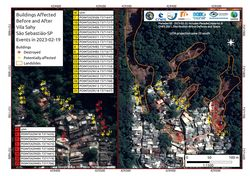


--- F.3 Verificando necessidade de Gráficos de Série Temporal para 2023-02-19 ---
  Encontrados alertas significativos em 2 estação(ões) para 2023-02-19: Bertioga, Franca
    Gerando gráfico de série temporal para Estação: Bertioga...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Bertioga_2023-02-17_a_2023-02-20.png


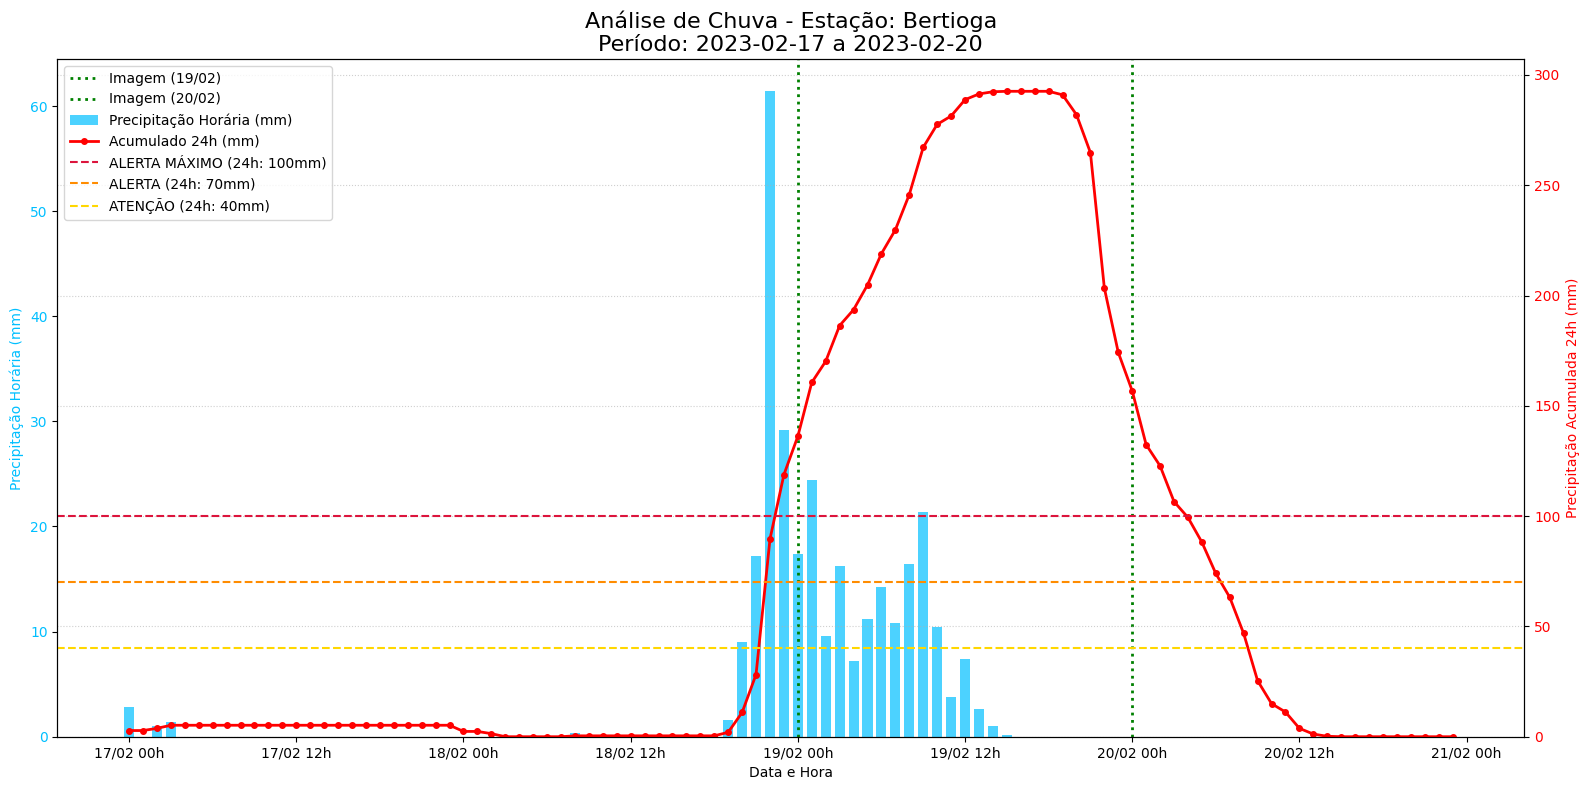

    Gerando gráfico de série temporal para Estação: Franca...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Franca_2023-02-17_a_2023-02-20.png


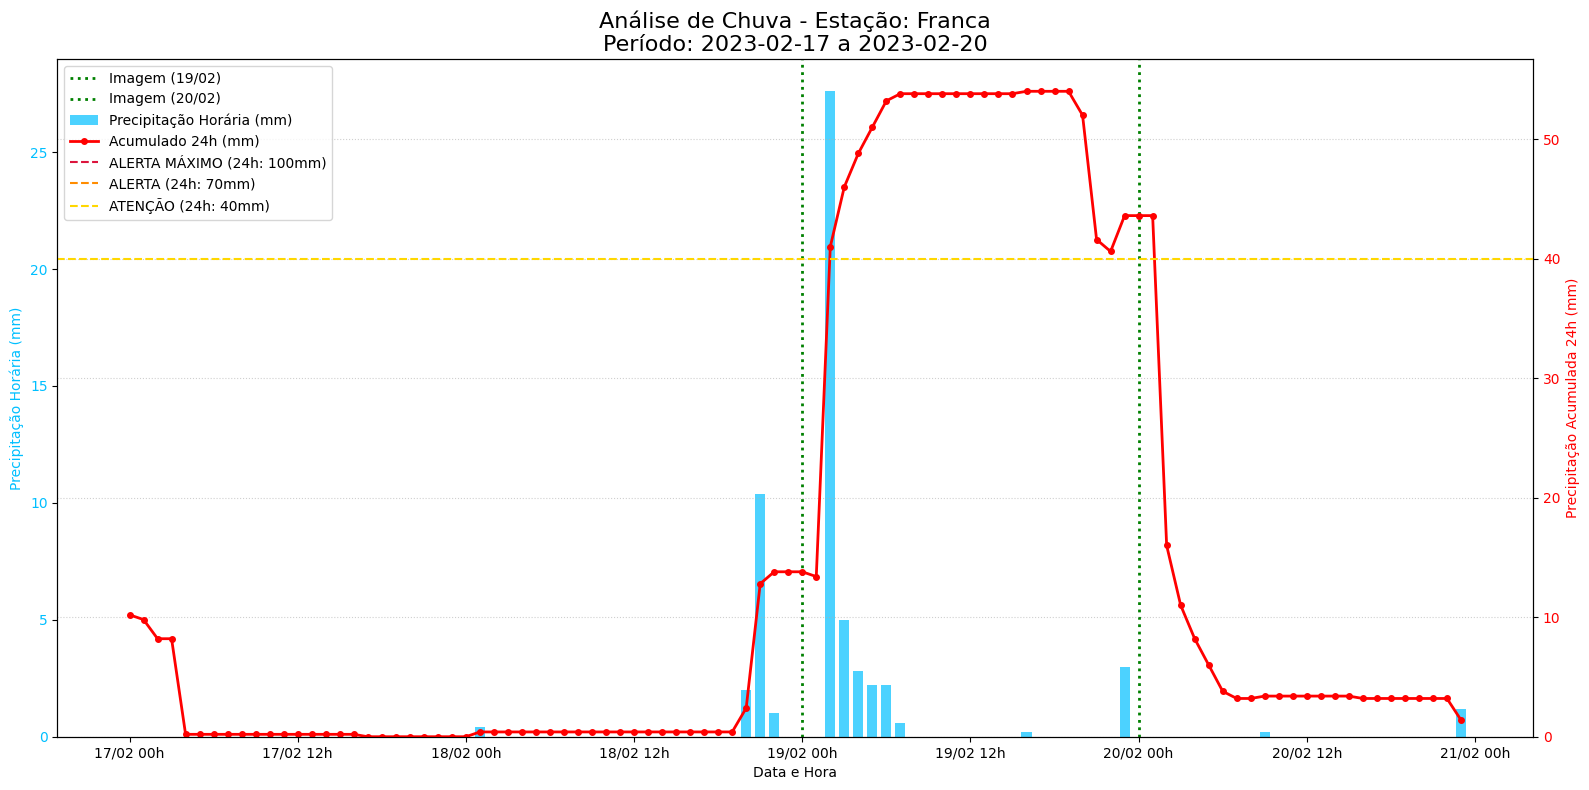


----- Processando data do evento: 2023-02-20 -----

--- F.1 Gerando Relatório de Evento para Imagem: activation-803-SP-São Sebastião-2023-02-20-01.jpeg ---
RELATÓRIO DE EVENTO CRÍTICO PARA IMAGEM: activation-803-SP-São Sebastião-2023-02-20-01.jpeg
Data extraída da imagem: 20/02/2023

--- RESUMO DOS ALERTAS DE CHUVA EM 20/02/2023 ---
- Total de Alertas Registrados no Dia: 65
- Contagem por Nível de Alerta:
  - ATENÇÃO: 28
  - ALERTA: 32
  - ALERTA MÁXIMO: 5
- Estações com Alertas: 4
- Municípios com Alertas: 4

--- DETALHES DOS ALERTAS MAIS CRÍTICOS ---
(Mostrando até 10 alertas mais significativos)

  Alerta Detalhe (Índice Original do Dia: 21470):
    Hora:         00:00:00
    Estação:      Bertioga
    Município:    Bertioga
    Coord.:       Lat -23.8447, Lon -46.1433
    Nível:        ALERTA MÁXIMO
    Descrição:    Acumulado >100mm em 24h - RISCO ALTO
    Valor Obs.:   156.8 mm (limiar: 100.0 mm)
    Gatilho:      prec_acum_24h

  Alerta Detalhe (Índice Original do Dia: 2147

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (162320760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Mapa de alertas com thumbnails relevantes salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/mapa_alertas_thumbnails_relevantes_20230220.html
Geração do mapa para 20/02/2023 concluída.



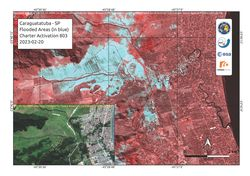


--- F.3 Verificando necessidade de Gráficos de Série Temporal para 2023-02-20 ---
  Encontrados alertas significativos em 2 estação(ões) para 2023-02-20: Bertioga, Sao Paulo - Mirante
    Gerando gráfico de série temporal para Estação: Bertioga...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Bertioga_2023-02-18_a_2023-02-21.png


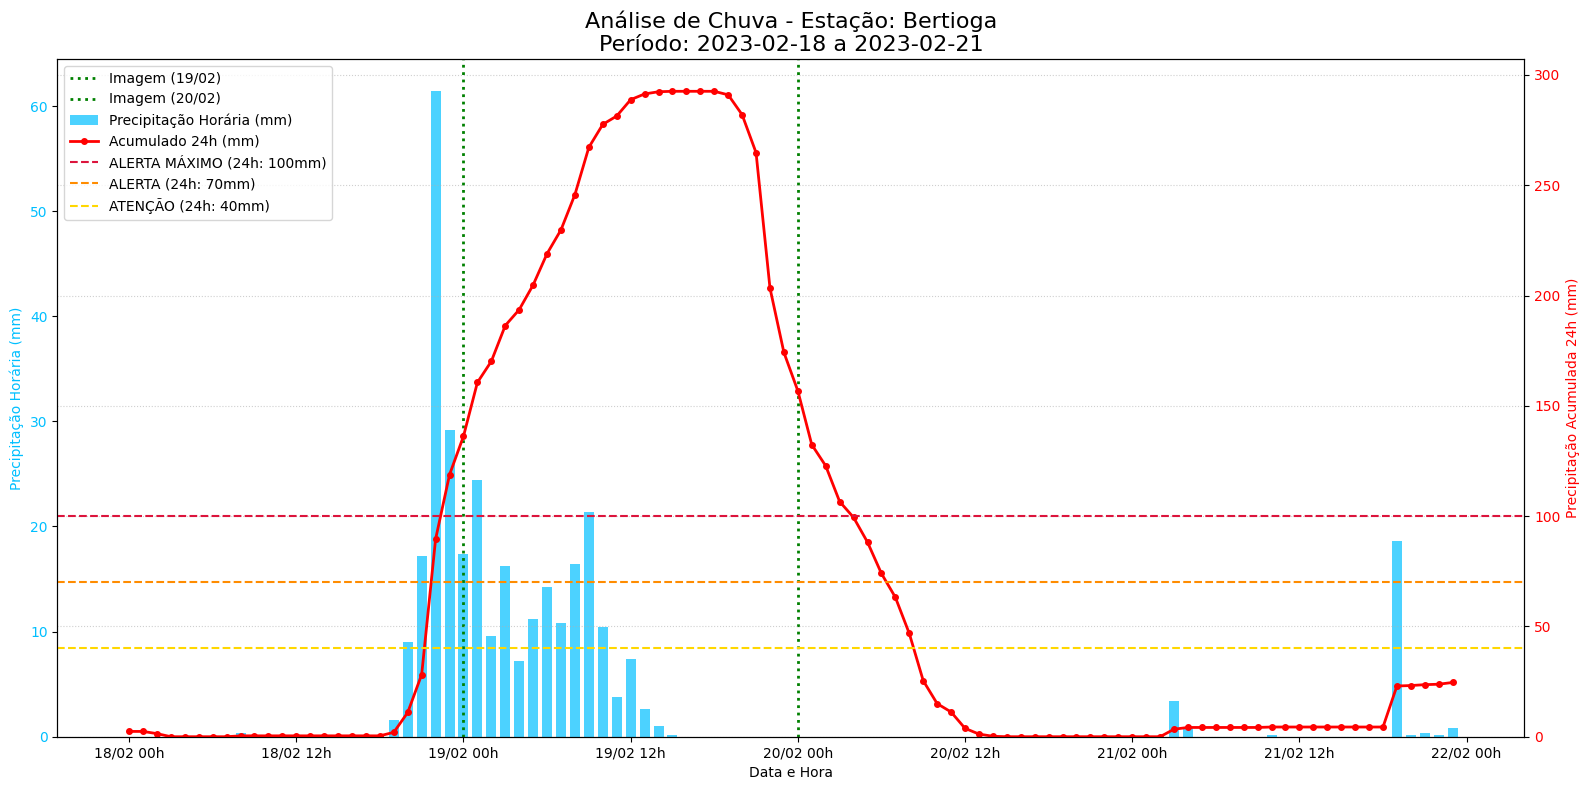

    Gerando gráfico de série temporal para Estação: Sao Paulo - Mirante...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Sao_Paulo_-_Mirante_2023-02-18_a_2023-02-21.png


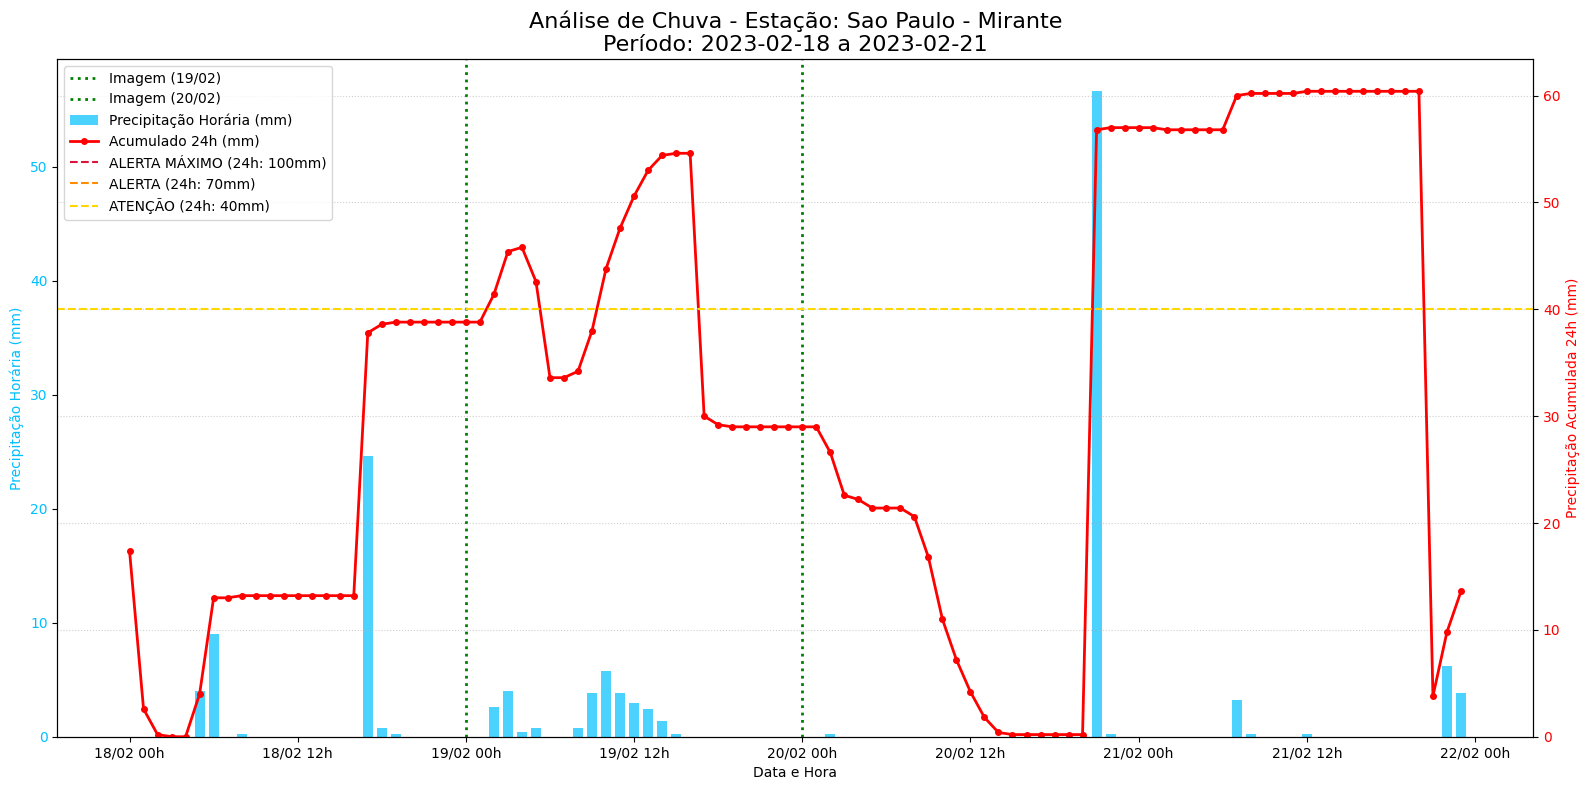


----- Processando data do evento: 2023-02-22 -----

--- F.1 Gerando Relatório de Evento para Imagem: activation-803-SP-São Sebastião-2023-02-22-01.jpeg ---
RELATÓRIO DE EVENTO CRÍTICO PARA IMAGEM: activation-803-SP-São Sebastião-2023-02-22-01.jpeg
Data extraída da imagem: 22/02/2023

--- RESUMO DOS ALERTAS DE CHUVA EM 22/02/2023 ---
- Total de Alertas Registrados no Dia: 25
- Contagem por Nível de Alerta:
  - ATENÇÃO: 22
  - ALERTA: 3
  - ALERTA MÁXIMO: 0
- Estações com Alertas: 2
- Municípios com Alertas: 2

--- DETALHES DOS ALERTAS MAIS CRÍTICOS ---
(Mostrando até 10 alertas mais significativos)

  Alerta Detalhe (Índice Original do Dia: 21539):
    Hora:         00:00:00
    Estação:      Bertioga
    Município:    Bertioga
    Coord.:       Lat -23.8447, Lon -46.1433
    Nível:        ALERTA
    Descrição:    Acumulado >150mm em 72h (solo saturado)
    Valor Obs.:   185.0 mm (limiar: 150.0 mm)
    Gatilho:      prec_acum_72h

  Alerta Detalhe (Índice Original do Dia: 21540):
 


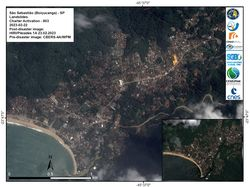
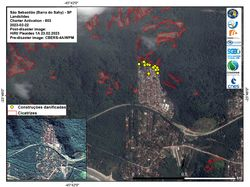


--- F.3 Verificando necessidade de Gráficos de Série Temporal para 2023-02-22 ---
  Encontrados alertas significativos em 1 estação(ões) para 2023-02-22: Bertioga
    Gerando gráfico de série temporal para Estação: Bertioga...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Bertioga_2023-02-20_a_2023-02-23.png


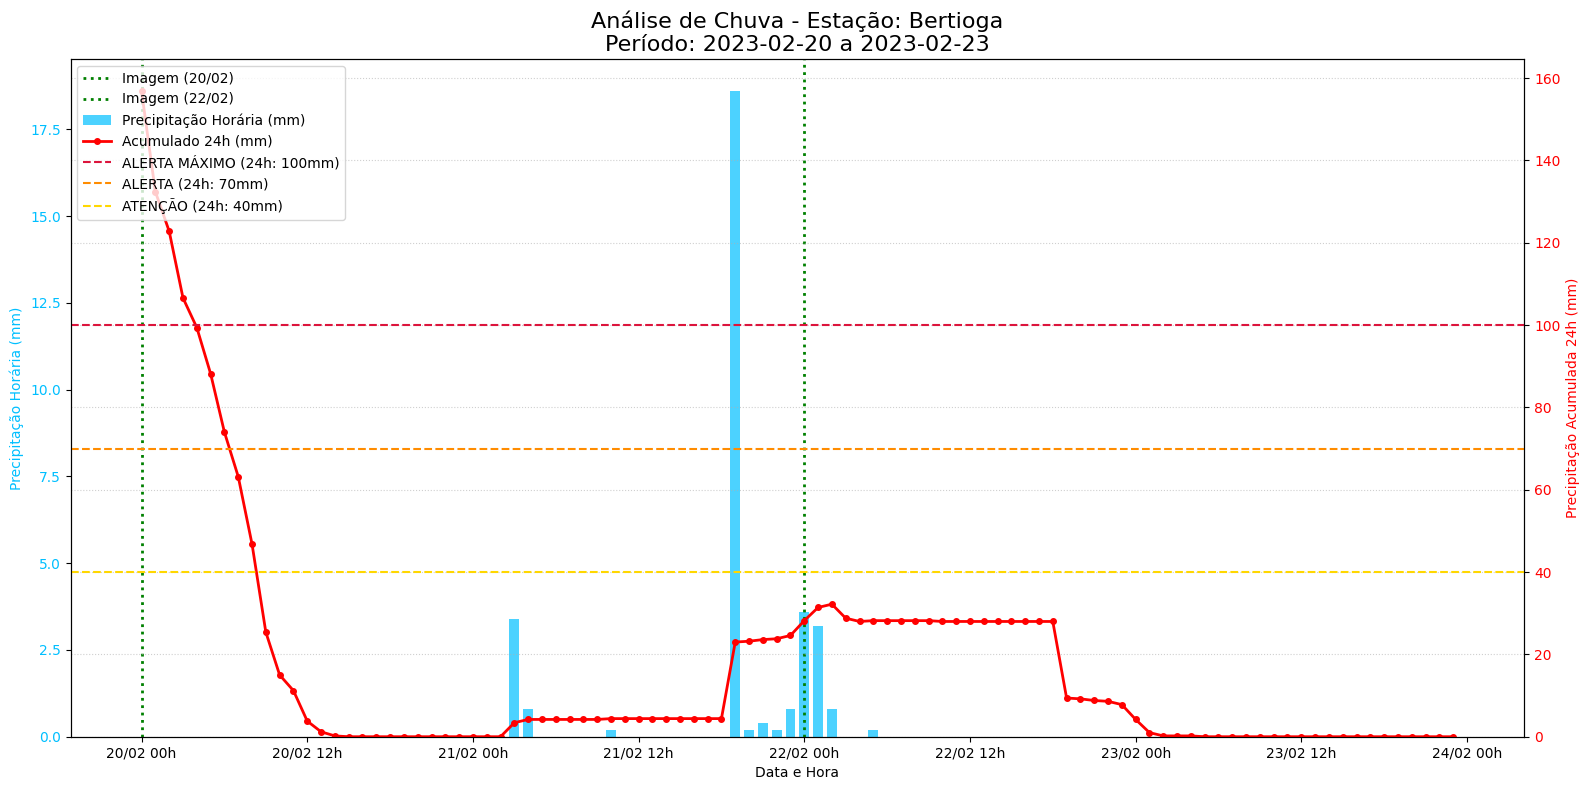


----- Processando data do evento: 2023-02-25 -----

--- F.1 Gerando Relatório de Evento para Imagem: activation-803-SP-São Sebastião-2023-02-25-01.jpeg ---
RELATÓRIO DE EVENTO CRÍTICO PARA IMAGEM: activation-803-SP-São Sebastião-2023-02-25-01.jpeg
Data extraída da imagem: 25/02/2023

--- RESUMO DOS ALERTAS DE CHUVA EM 25/02/2023 ---
- Total de Alertas Registrados no Dia: 4
- Contagem por Nível de Alerta:
  - ATENÇÃO: 2
  - ALERTA: 1
  - ALERTA MÁXIMO: 1
- Estações com Alertas: 2
- Municípios com Alertas: 2

--- DETALHES DOS ALERTAS MAIS CRÍTICOS ---
(Mostrando até 10 alertas mais significativos)

  Alerta Detalhe (Índice Original do Dia: 83616):
    Hora:         20:00:00
    Estação:      Sao Carlos
    Município:    São Carlos
    Coord.:       Lat -21.9804, Lon -47.8839
    Nível:        ALERTA MÁXIMO
    Descrição:    Chuva MUITO FORTE em 1h (>25mm)
    Valor Obs.:   25.2 mm (limiar: 25.0 mm)
    Gatilho:      prec_acum_1h

  Alerta Detalhe (Índice Original do Dia: 83617):
   


--- F.3 Verificando necessidade de Gráficos de Série Temporal para 2023-02-25 ---
  Encontrados alertas significativos em 1 estação(ões) para 2023-02-25: Sao Carlos
    Gerando gráfico de série temporal para Estação: Sao Carlos...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Sao_Carlos_2023-02-23_a_2023-02-26.png


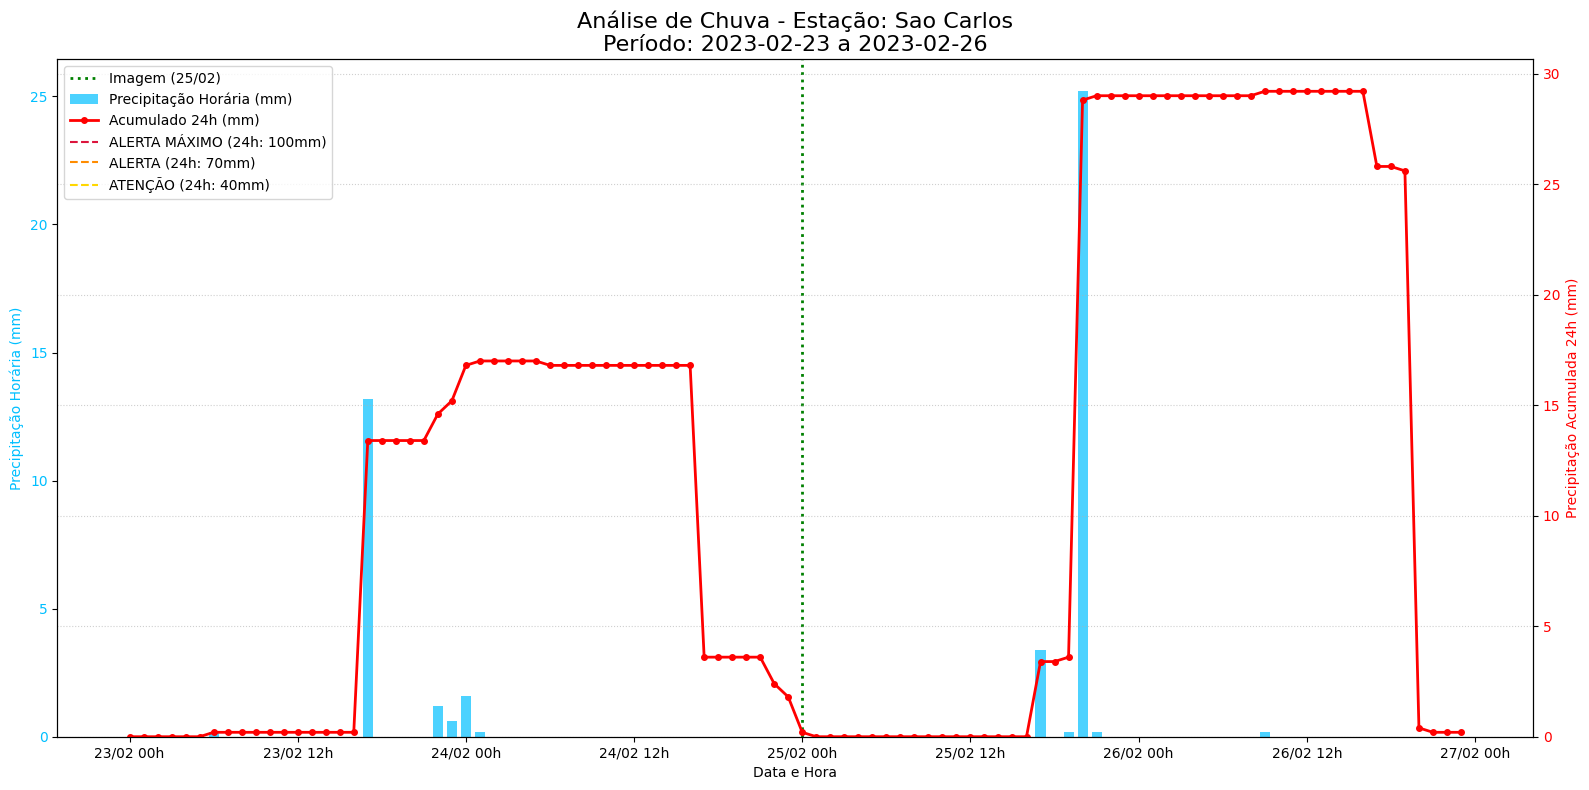


----- Processando data do evento: 2023-02-28 -----

--- F.1 Gerando Relatório de Evento para Imagem: activation-803-SP-São Sebastião-2023-02-28-01.jpeg ---
RELATÓRIO DE EVENTO CRÍTICO PARA IMAGEM: activation-803-SP-São Sebastião-2023-02-28-01.jpeg
Data extraída da imagem: 28/02/2023

--- RESUMO DOS ALERTAS DE CHUVA EM 28/02/2023 ---
- Total de Alertas Registrados no Dia: 37
- Contagem por Nível de Alerta:
  - ATENÇÃO: 20
  - ALERTA: 15
  - ALERTA MÁXIMO: 2
- Estações com Alertas: 4
- Municípios com Alertas: 4

--- DETALHES DOS ALERTAS MAIS CRÍTICOS ---
(Mostrando até 10 alertas mais significativos)

  Alerta Detalhe (Índice Original do Dia: 50183):
    Hora:         20:00:00
    Estação:      Itapira
    Município:    Itapira
    Coord.:       Lat -22.4150, Lon -46.8053
    Nível:        ALERTA MÁXIMO
    Descrição:    Chuva MUITO FORTE em 1h (>25mm)
    Valor Obs.:   44.8 mm (limiar: 25.0 mm)
    Gatilho:      prec_acum_1h

  Alerta Detalhe (Índice Original do Dia: 21542):
    Ho


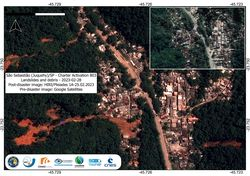
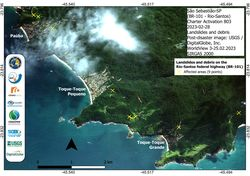
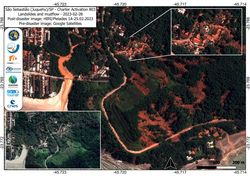
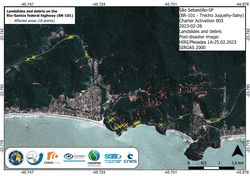


--- F.3 Verificando necessidade de Gráficos de Série Temporal para 2023-02-28 ---
  Encontrados alertas significativos em 4 estação(ões) para 2023-02-28: Bertioga, Itapira, Barueri, Taubate
    Gerando gráfico de série temporal para Estação: Bertioga...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Bertioga_2023-02-26_a_2023-03-01.png


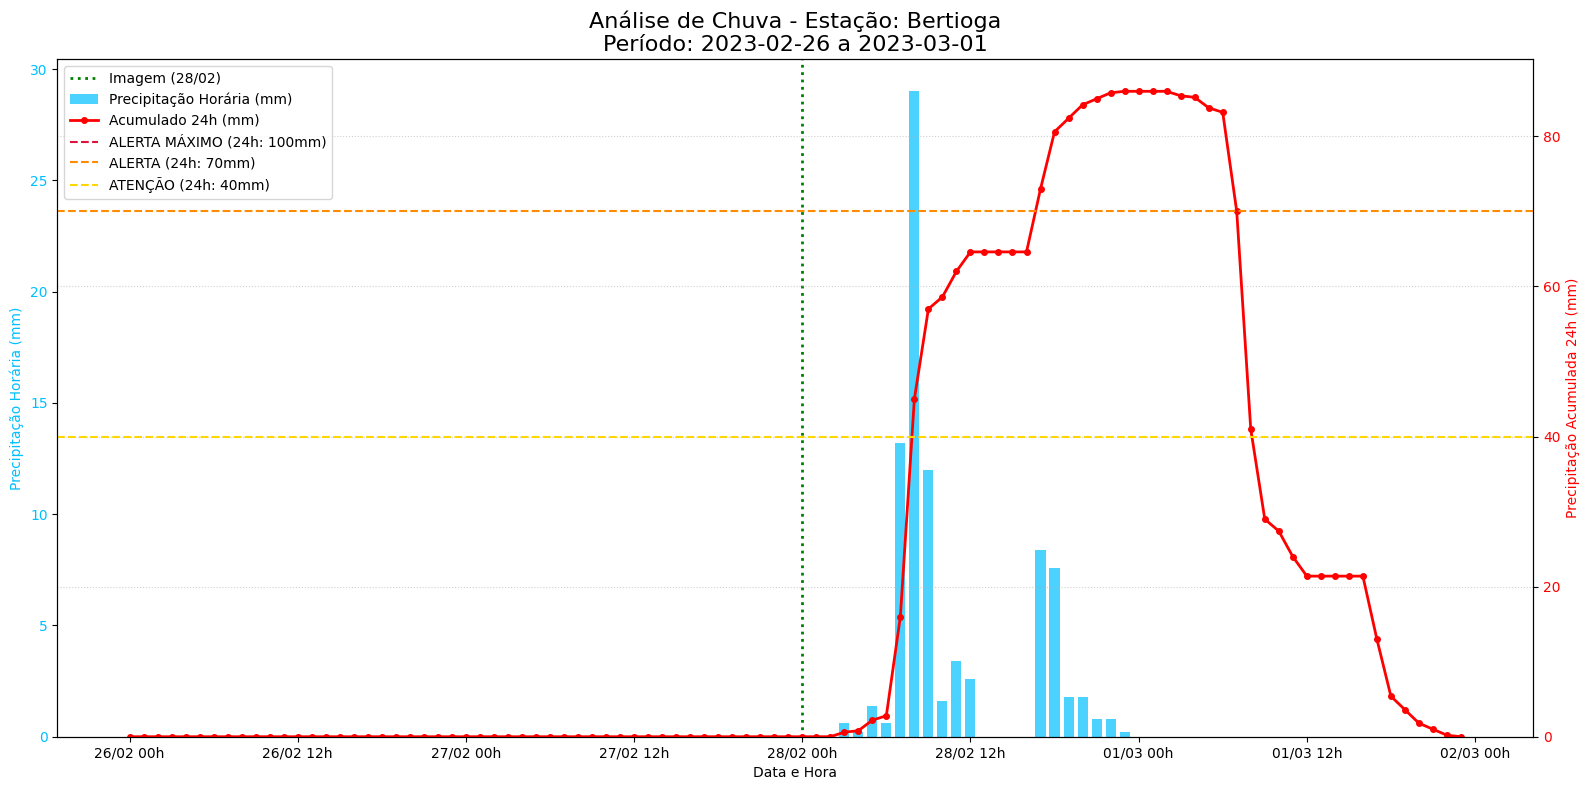

    Gerando gráfico de série temporal para Estação: Itapira...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Itapira_2023-02-26_a_2023-03-01.png


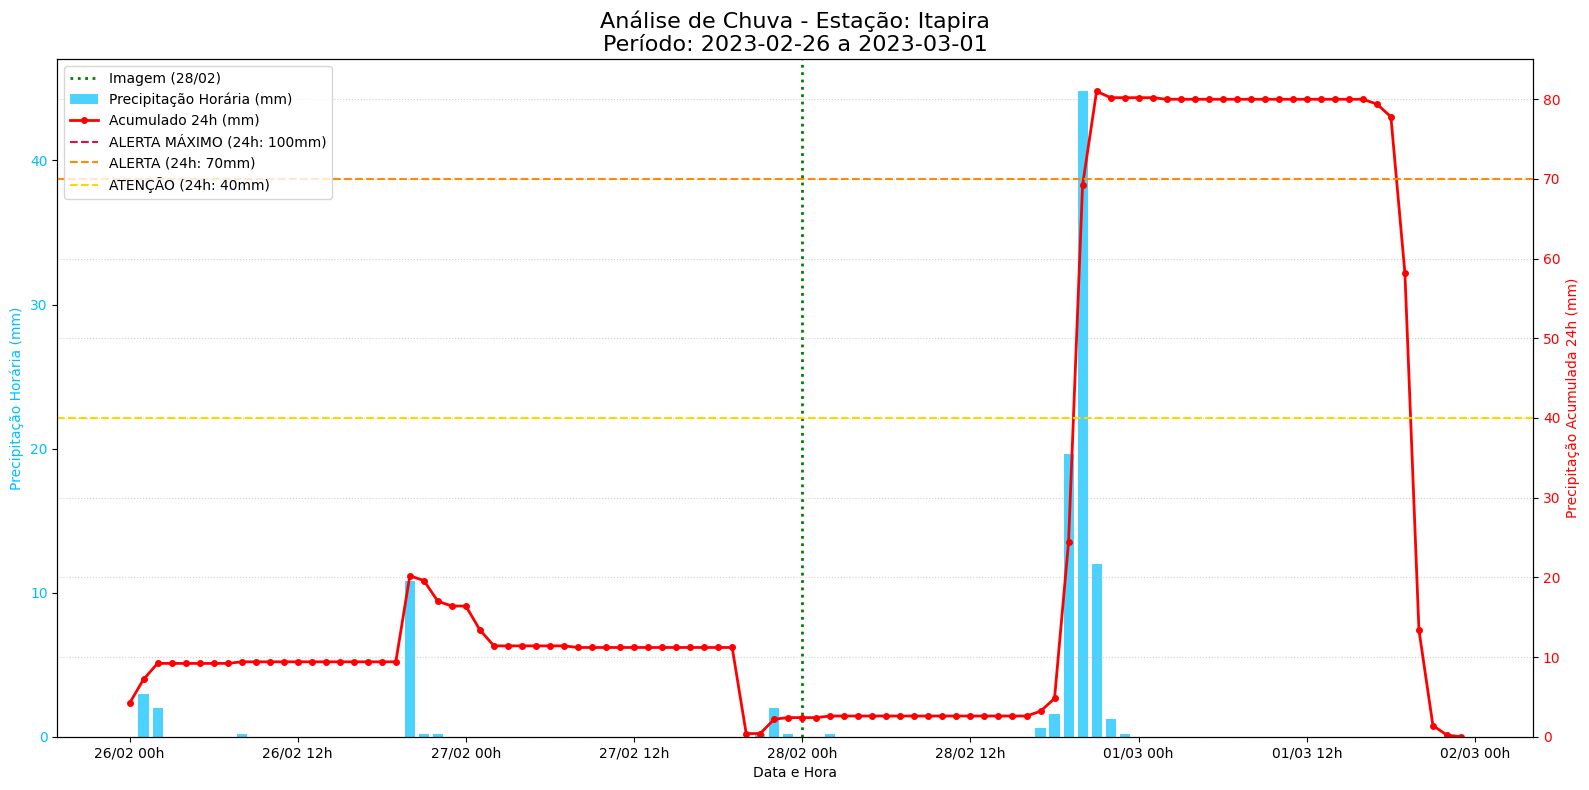

    Gerando gráfico de série temporal para Estação: Barueri...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Barueri_2023-02-26_a_2023-03-01.png


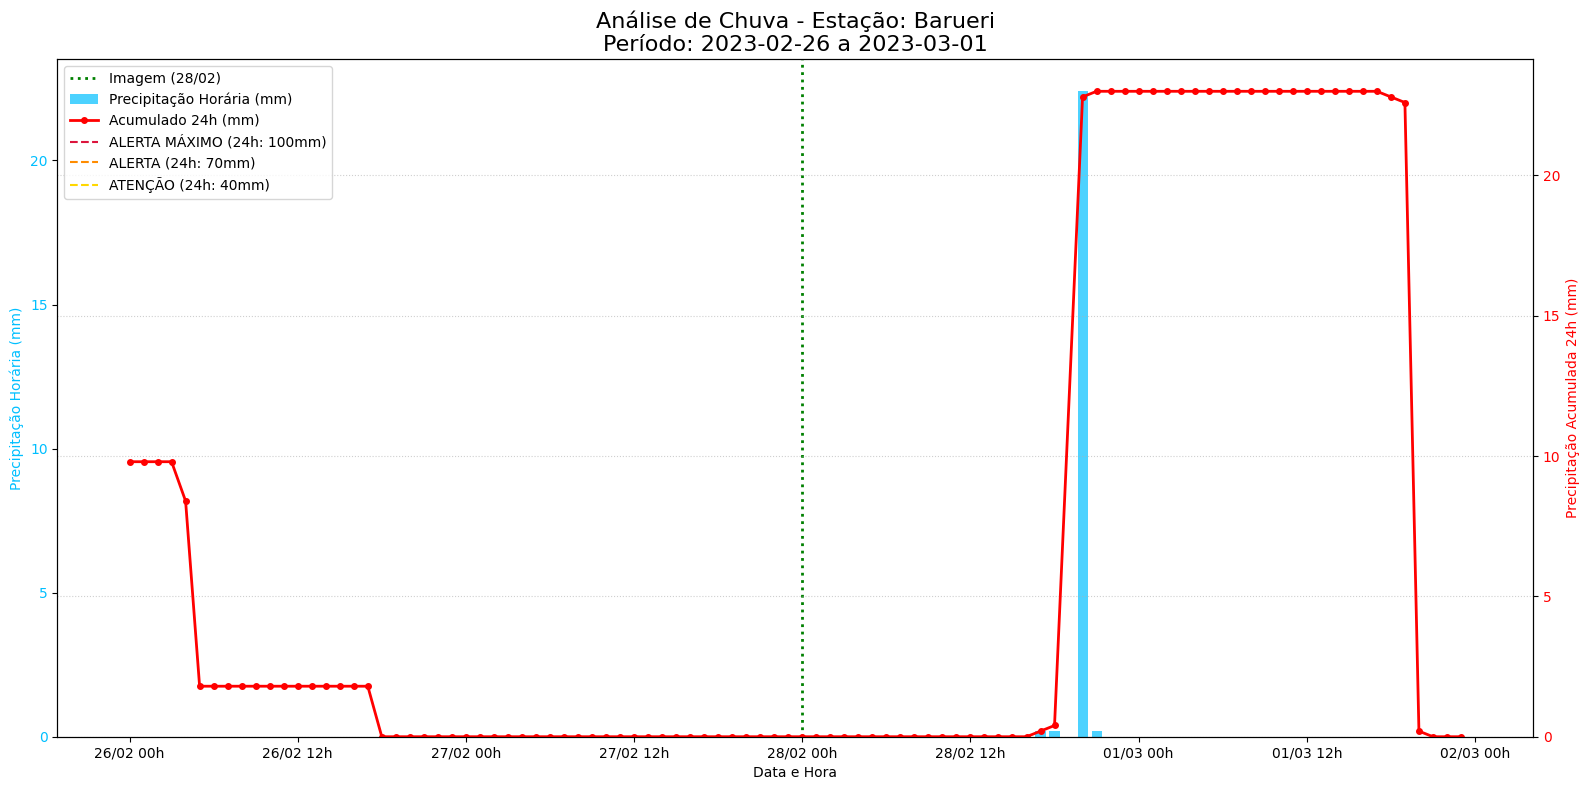

    Gerando gráfico de série temporal para Estação: Taubate...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Taubate_2023-02-26_a_2023-03-01.png


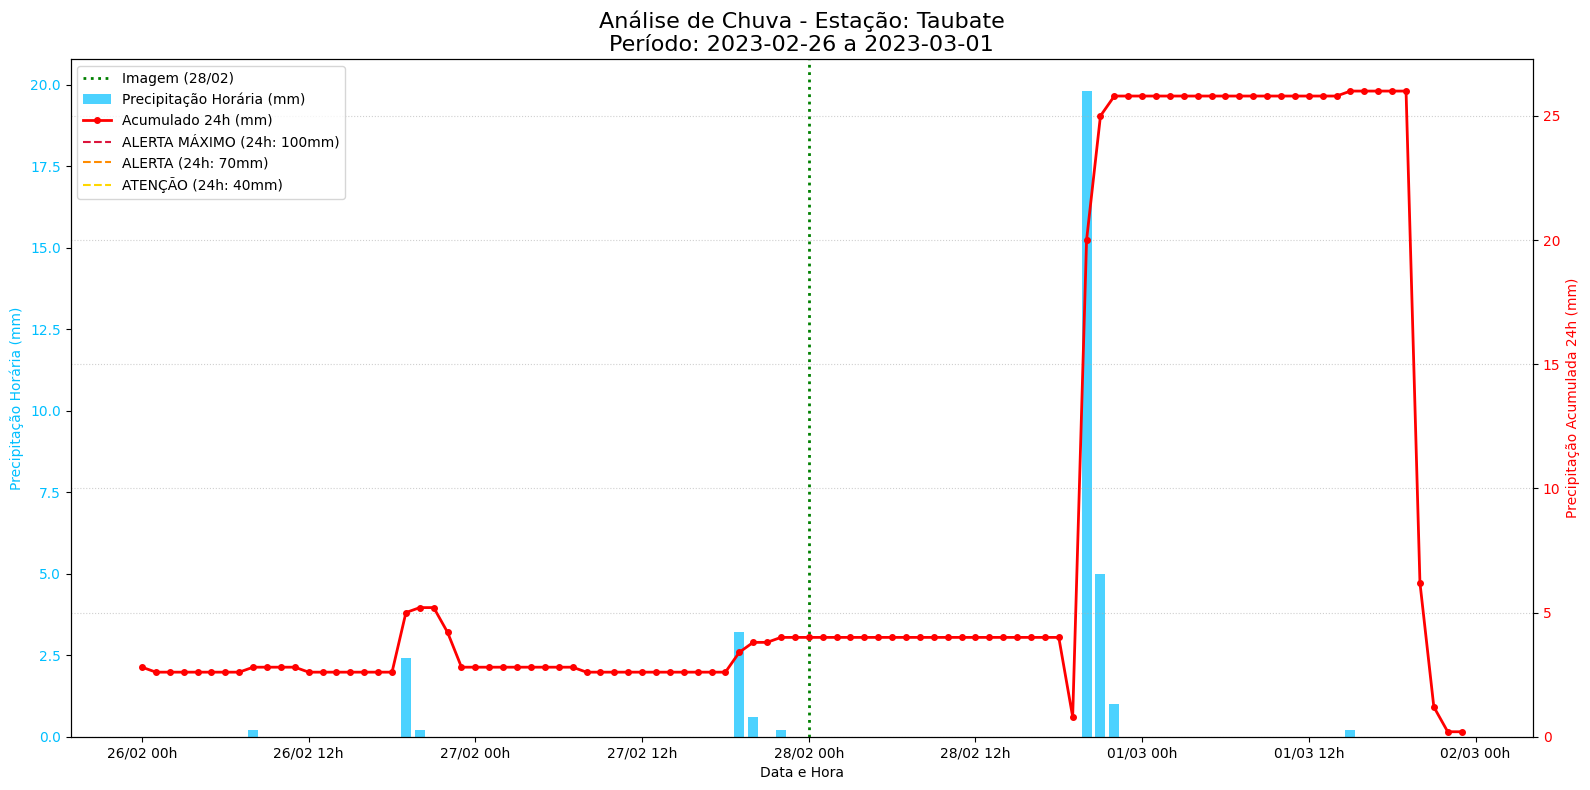


----- Processando data do evento: 2023-03-23 -----

--- F.1 Gerando Relatório de Evento para Imagem: activation-803-SP-São Sebastião-2023-03-23-01.jpeg ---
RELATÓRIO DE EVENTO CRÍTICO PARA IMAGEM: activation-803-SP-São Sebastião-2023-03-23-01.jpeg
Data extraída da imagem: 23/03/2023

--- RESUMO DOS ALERTAS DE CHUVA EM 23/03/2023 ---
- Total de Alertas Registrados no Dia: 5
- Contagem por Nível de Alerta:
  - ATENÇÃO: 5
  - ALERTA: 0
  - ALERTA MÁXIMO: 0
- Estações com Alertas: 1
- Municípios com Alertas: 1

--- DETALHES DOS ALERTAS MAIS CRÍTICOS ---
(Mostrando até 10 alertas mais significativos)

  Alerta Detalhe (Índice Original do Dia: 17557):
    Hora:         00:00:00
    Estação:      Bebedouro
    Município:    Bebedouro
    Coord.:       Lat -20.9492, Lon -48.4900
    Nível:        ATENÇÃO
    Descrição:    Acumulado >40mm em 24h - Atenção
    Valor Obs.:   44.2 mm (limiar: 40.0 mm)
    Gatilho:      prec_acum_24h

  Alerta Detalhe (Índice Original do Dia: 17558):
    Hora:


--- F.3 Verificando necessidade de Gráficos de Série Temporal para 2023-03-23 ---
  Nenhum alerta de nível 'ALERTA' ou 'ALERTA MÁXIMO' encontrado para 2023-03-23. Nenhum gráfico de série temporal específico será gerado automaticamente para esta data.

----- Processando data do evento: 2023-03-27 -----

--- F.1 Gerando Relatório de Evento para Imagem: activation-803-SP-São Sebastião-2023-03-27-01.jpeg ---
RELATÓRIO DE EVENTO CRÍTICO PARA IMAGEM: activation-803-SP-São Sebastião-2023-03-27-01.jpeg
Data extraída da imagem: 27/03/2023

--- RESUMO DOS ALERTAS DE CHUVA EM 27/03/2023 ---
- Total de Alertas Registrados no Dia: 24
- Contagem por Nível de Alerta:
  - ATENÇÃO: 22
  - ALERTA: 2
  - ALERTA MÁXIMO: 0
- Estações com Alertas: 2
- Municípios com Alertas: 2

--- DETALHES DOS ALERTAS MAIS CRÍTICOS ---
(Mostrando até 10 alertas mais significativos)

  Alerta Detalhe (Índice Original do Dia: 1183):
    Hora:         18:00:00
    Estação:      Ariranha
    Município:    Ariranha
    Coo


--- F.3 Verificando necessidade de Gráficos de Série Temporal para 2023-03-27 ---
  Encontrados alertas significativos em 2 estação(ões) para 2023-03-27: Iguape, Ariranha
    Gerando gráfico de série temporal para Estação: Iguape...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Iguape_2023-03-25_a_2023-03-28.png


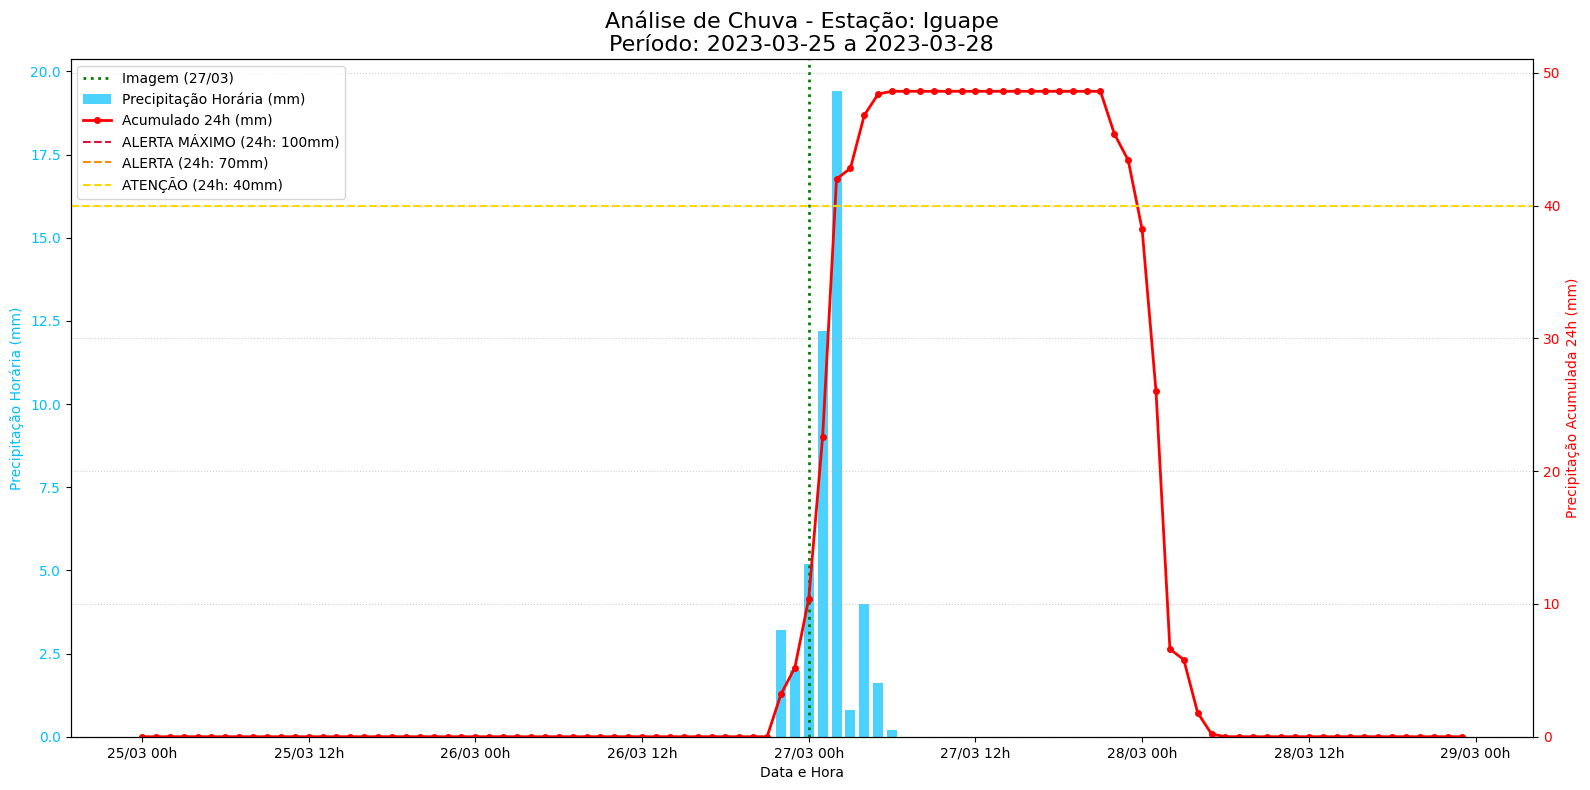

    Gerando gráfico de série temporal para Estação: Ariranha...
Gráfico salvo em: /content/drive/MyDrive/Colab Notebooks/FIAP/Global/outputs_gerados/plot_chuva_Ariranha_2023-03-25_a_2023-03-28.png


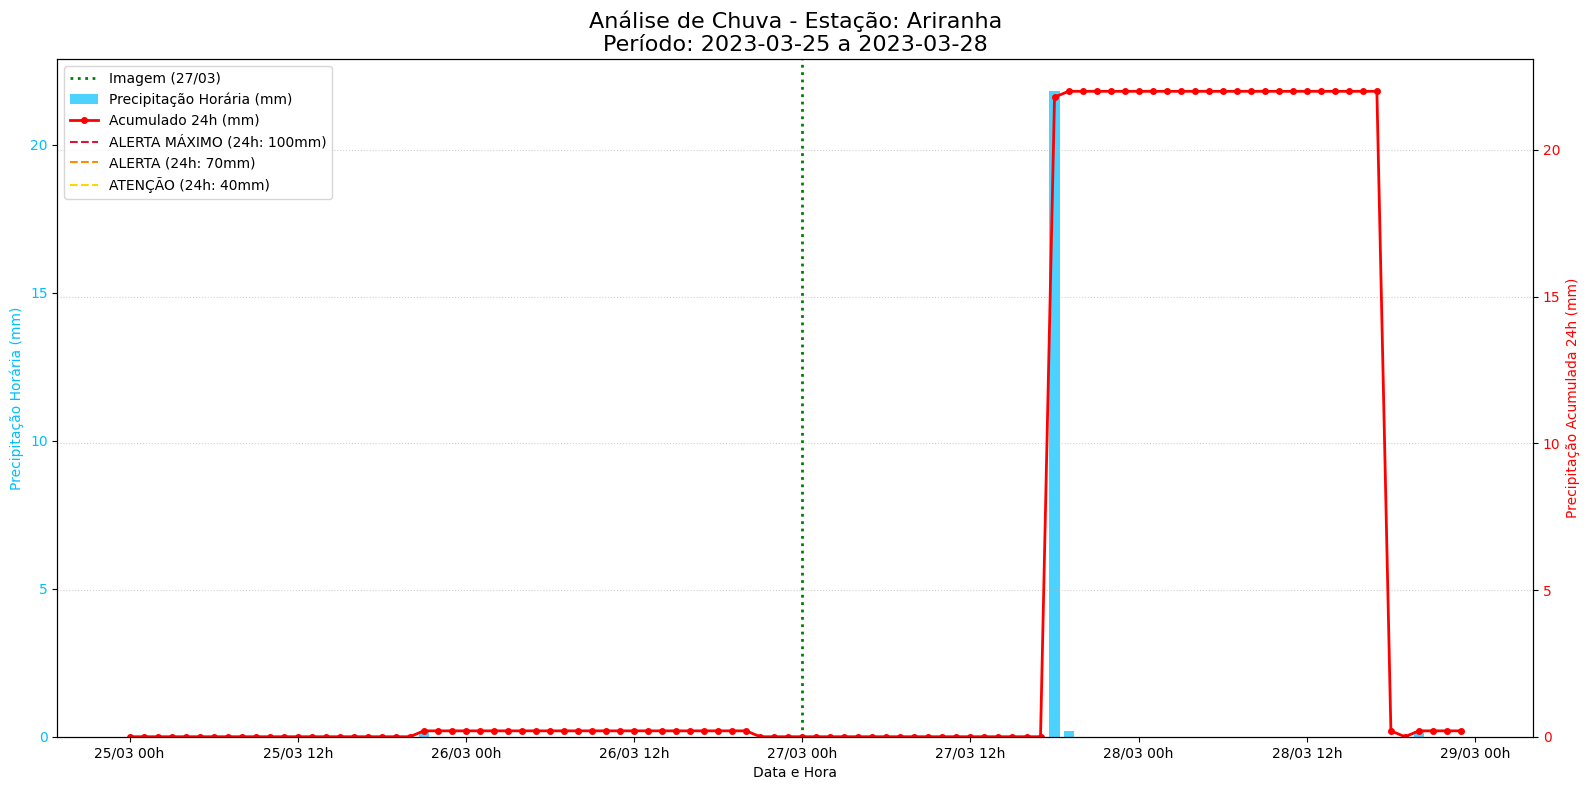


################################################################################
SCRIPT DE ANÁLISE DE EVENTOS CLIMÁTICOS CONCLUÍDO
################################################################################



In [28]:
# -----------------------------------------------------------------------------
# CHAMADA DA FUNÇÃO PRINCIPAL
# -----------------------------------------------------------------------------
if __name__ == '__main__':
    main()